# Analysis of a Sample Resection

We have TVB connectivity data for:

- healthy subject
- epileptic successful resection
- epileptic failed resection

The goal of this simulation is to show that neural fragility can guide resection and is linked to highlighting the epileptogenic zone and possibly propagation zones in the neural network. The simulations will proceed as follows:

1. Load connectivity data and instantiate the simulation(s)
2. Run simulation and save intermediately generated simulated neural mass time series, sEEG time series and scalp EEG time series
3. Run fragility analysis

Notes on Simulation
===================
Note that the Epileptor is a generative model based on a stochastic differential equation, so therefore different parameters can vary in (nonlinear) ways that will produce different system behaviors. Namely, the `x0` parameter is said to impose the "degree of epileptogenicity" in the model. Regions with `x0 > -2.1` will spontaneously produce seizures. 

Note that we will set EZ regions with `x0 = -1.6`, PZ with `x0=-2.0` and normal regions with `x0=-2.4`.


References
----------
1. [Predicting the spatiotemporal diversity of seizure propagation and termination in human focal epilepsy](https://arxiv.org/pdf/1707.00772.pdf)
2. [On the Nature of Seizure Dynamics](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4107736/pdf/awu133.pdf)

In [6]:
import numpy as np
import pandas as pd
import mne
from pprint import pprint

import os
import json
import os.path as op
from pathlib import Path
import collections

from sklearn.datasets import make_spd_matrix
from mne.io import RawArray
from mne import create_info
from mne_bids import BIDSPath, get_entity_vals, read_raw_bids
import mne
mne.utils.use_log_level('error')
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import scipy

import dabest
import pydmd

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, explained_variance_score

from mne_features.univariate import compute_spect_slope
from mne_features.utils import power_spectrum

from eztrack.io.base import _add_desc_to_bids_fname, concatenate_derivs
from eztrack.io import read_derivative_npy, create_deriv_info, DerivativeArray
from eztrack.fragility import (lds_raw_fragility, DiscreteLinearSystem, 
                               SystemIDModel, StructuredPerturbationModel)
from eztrack.viz import _load_turbo, generate_heatmap
from eztrack.posthoc.hypo import compute_null

import sys
sys.path.append('../../')
from sickkids.dmd.dmd import rescale_modes
from sickkids.posthoc.spectral import compute_significant_freqs, compute_bootstrap_lr
from sickkids.tvb.simulation import load_subject_connectivity, setup_simulation, resect_regions
from sickkids.tvb.utils import read_surf


_load_turbo()

# %matplotlib widget
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
np.random.seed(12345)

In [8]:
def compute_resected_chs_on_vertices(verts, regmap, ezinds, ch_xyz):
    # map EZ indices to vertex rows
    ez_vert_idx = np.argwhere(any([idx in regmap for idx in ezinds]))
    
    # map now to vertices
    ez_verts = verts[ez_vert_idx, :]
    
    # get ch_xyz with respect to the vertices
    
    
    # get the minimum distance of each channel and check if that vertex 
    # is in/near the EZ
    
    return resected_chs

In [9]:
from tvb.simulator.lab import (
    coupling, monitors, simulator, noise, integrators, models, connectivity,
    region_mapping
)


In [10]:
# add tvb utility data to path
tvb_data_path = '/Users/adam2392/Documents/tvb_data/tvb_data/'
sys.path.append(tvb_data_path)

In [11]:
# %pylab nbagg

In [12]:
# from tvb.simulator.plot.phase_plane_interactive import PhasePlaneInteractive

# # Create an Epileptor model instance
# epileptor = models.Epileptor()

# # Open the phase plane tool with the epileptor model
# ppi_fig = PhasePlaneInteractive(model=epileptor)
# ppi_fig.show()

In [13]:
# paths to data
root = Path('/Users/adam2392/Dropbox/resection_tvb/')
source_path = root / 'sourcedata'
experimental_condition = 'epilepsy'
subject = 'id008_gc'
subject = 'id013_pg'

subj_path = source_path / experimental_condition / subject
source_file = subj_path / 'tvb' / 'connectivity.zip'

In [14]:
output_path = Path('/Users/adam2392/OneDrive - Johns Hopkins/sickkids/derivatives/tvb')
output_path.mkdir(exist_ok=True, parents=True)

# Load Connectivity Data

We will load a preprocessed TVB connectivity dataset, which contains:

- areas.txt = The surface area in mm^3 of each region parcellation
- average_orientations.txt = The 3D orientation of each region parcellation
- centres.txt = The 3D centroid of each region
- cortical.txt = A binary flag of which region(s) are part of the cortical surface (others are part of the subcortical surface)
- tract_lengths.txt = The pairwise tract lengths matrix between all regions
- weights.txt = The pairwise weight matrix between all regions

In most of our datasets, these will be constructed from a `Desikan` atlas, which comprises of 84 distinct brain regions.

In [15]:
conn = load_subject_connectivity(
    source_file=str(source_file), condspeed=3.
)

WARNING  File 'hemispheres' not found in ZIP.


In [18]:
# show the summary for this subject
print(conn)

Connectivity (
  Number of connections ........................ 0
  Number of regions ............................ 0
  Undirected ................................... False
  areas [min, median, max] ..................... [340.84, 2223.93, 16020.4]
  areas dtype .................................. float64
  areas shape .................................. (84,)
  tract_lengths (connections) [min, median, max]  [12.19, 118.817, 197.187]
  tract_lengths [min, median, max] ............. [0, 116.056, 197.187]
  tract_lengths-non-zero [min, median, max] .... [12.19, 118.817, 197.187]
  weights [min, median, max] ................... [0, 0.000223561, 1]
  weights dtype ................................ float64
  weights shape ................................ (84, 84)
  weights-non-zero [min, median, max] .......... [3.54859e-06, 0.000266144, 1]
)


<ipython-input-17-42e25eb72286>:4: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(conn.weights), interpolation='nearest', aspect='equal', cmap='viridis')


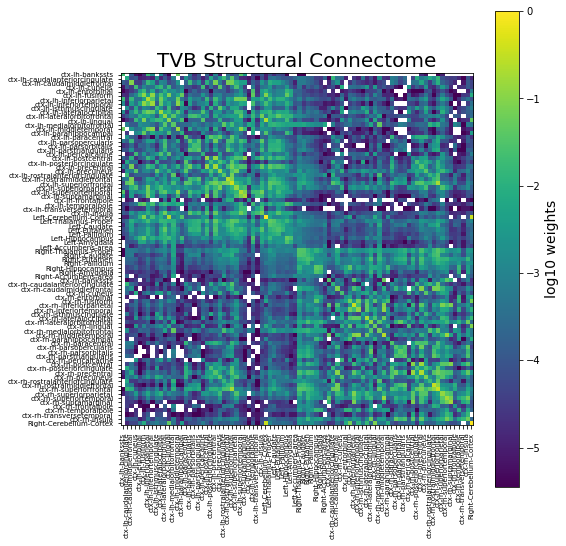

In [17]:
nregions = len(conn.region_labels)
# Visualization.
plt.figure(figsize=(8,8))
plt.imshow(np.log10(conn.weights), interpolation='nearest', aspect='equal', cmap='viridis')
plt.title('TVB Structural Connectome', fontsize=20)
plt.xticks(range(0, nregions), conn.region_labels, fontsize=7, rotation=90)
plt.yticks(range(0, nregions), conn.region_labels, fontsize=7)
cb=plt.colorbar(
#     shrink=0.8
)
cb.set_label('log10 weights', fontsize=14)
plt.tight_layout()
plt.show()

# Load in Channel Coordinates

Channel coordinates in 3D brain space should have been localized on a CT image and then coregistred and mapped to the brain space that the connectivity data was constructed from. This is generally derived from FreeSurfer.

Here is an example figure layout of sEEG electrode coordinates in 3 snapshots of Anterior/Posterior, Inferior/Superior, and Left/Right.
<div>
<img src="./seeg.png" width="70%"/>
</div>

In [602]:
from itertools import islice

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

In [603]:
# first load in the channel's xyz coordinates
ch_xyz_fpath = subj_path / 'elec' / 'seeg.txt'

seeg_pd = pd.read_csv(
    ch_xyz_fpath, names=['x', 'y', 'z'], delim_whitespace=True)

ch_names = seeg_pd.index.values
ch_xyz = seeg_pd.to_numpy()
ch_pos = seeg_pd.T.to_dict(orient='list')

In [604]:
# got all the channels!
print(ch_names)
pprint(take(5, ch_pos.items()))

['R1' 'R2' 'R3' 'R4' 'R5' 'R6' 'R7' 'R8' 'R9' 'R10' 'R11' 'CR1' 'CR2'
 'CR3' 'CR4' 'CR5' 'CR6' 'CR7' 'CR8' 'CR9' 'CR10' 'CR11' 'FD1' 'FD2' 'FD3'
 'FD4' 'FD5' 'FD6' 'FD7' 'FD8' 'FD9' 'FD10' 'FD11' 'CC1' 'CC2' 'CC3' 'CC4'
 'CC5' 'CC6' 'CC7' 'CC8' 'CC9' 'CC10' 'CC11' 'TP1' 'TP2' 'TP3' 'TP4' 'TP5'
 'TP6' 'A1' 'A2' 'A3' 'A4' 'A5' 'A6' 'A7' 'A8' 'A9' 'A10' 'A11' 'A12'
 'A13' 'B1' 'B2' 'B3' 'B4' 'B5' 'B6' 'B7' 'B8' 'B9' 'B10' 'B11' 'B12'
 'B13' 'GPH1' 'GPH2' 'GPH3' 'GPH4' 'GPH5' 'GPH6' 'GPH7' 'GPH8' 'GPH9'
 'GPH10' 'GPH11' 'GPH12' 'T1' 'T2' 'T3' 'T4' 'OR1' 'OR2' 'OR3' 'OR4' 'OR5'
 'OR6' 'OR7' 'OR8' 'OR9' 'OR10' 'OR11']
[('R1', [-5.98, 56.97, 6.7]),
 ('R2', [-2.49, 57.24, 6.82]),
 ('R3', [1.0, 57.51, 6.94]),
 ('R4', [4.48, 57.78, 7.06]),
 ('R5', [7.97, 58.05, 7.19])]


In [605]:
gain_inv_fname = subj_path / 'elec' / 'gain_inv-square.txt'

print(gain_inv_fname)

/Users/adam2392/Dropbox/resection_tvb/sourcedata/epilepsy/id008_gc/elec/gain_inv-square.txt


# Initialize Epileptor Models At Brain Regions

In [606]:
print(conn.region_labels)

['ctx-lh-bankssts' 'ctx-lh-caudalanteriorcingulate'
 'ctx-lh-caudalmiddlefrontal' 'ctx-lh-cuneus' 'ctx-lh-entorhinal'
 'ctx-lh-fusiform' 'ctx-lh-inferiorparietal' 'ctx-lh-inferiortemporal'
 'ctx-lh-isthmuscingulate' 'ctx-lh-lateraloccipital'
 'ctx-lh-lateralorbitofrontal' 'ctx-lh-lingual'
 'ctx-lh-medialorbitofrontal' 'ctx-lh-middletemporal'
 'ctx-lh-parahippocampal' 'ctx-lh-paracentral' 'ctx-lh-parsopercularis'
 'ctx-lh-parsorbitalis' 'ctx-lh-parstriangularis' 'ctx-lh-pericalcarine'
 'ctx-lh-postcentral' 'ctx-lh-posteriorcingulate' 'ctx-lh-precentral'
 'ctx-lh-precuneus' 'ctx-lh-rostralanteriorcingulate'
 'ctx-lh-rostralmiddlefrontal' 'ctx-lh-superiorfrontal'
 'ctx-lh-superiorparietal' 'ctx-lh-superiortemporal'
 'ctx-lh-supramarginal' 'ctx-lh-frontalpole' 'ctx-lh-temporalpole'
 'ctx-lh-transversetemporal' 'ctx-lh-insula' 'Left-Cerebellum-Cortex'
 'Left-Thalamus-Proper' 'Left-Caudate' 'Left-Putamen' 'Left-Pallidum'
 'Left-Hippocampus' 'Left-Amygdala' 'Left-Accumbens-area'
 'Right-Thala

In [607]:
if subject == 'id013_pg':
    ez_label = ['ctx-rh-fusiform', 
#                 'Right-Hippocampus', 'Right-Amygdala'
               ]
    pz_label = ['Right-Hippocampus', 'Right-Amygdala', 
#                 'ctx-rh-middltemporal', 
                'ctx-rh-inferiortemporal',
#                 'ctx-rh-entorhinal'
               ] 
elif subject == 'id008_gc':
    ez_label = ['Right-Amygdala', 'Right-Hippocampus', 
#                                'ctx-rh-medialorbitofrontal',
               ]
    pz_label = [
#         'ctx-rh-superiortemporal', 
#                 'ctx-rh-middletemporal', 
                'ctx-rh-inferiortemporal', 
                'ctx-rh-temporalpole',
#                 'ctx-rh-lateralorbitofrontal'
               ]
else:
    ez_label = None
    pz_label = None

In [608]:
# read in the ez hypothesis regions
with open(subj_path / 'tvb' / 'ez_hypothesis.txt', 'r') as fin:
    ez_hypo = pd.read_csv(fin, delimiter='\n').to_numpy().squeeze()
print(ez_hypo)
ezhypo_inds = ez_hypo[np.argwhere(ez_hypo == 1)]

# get the hypothesized EZ and PZ
ezhypo_inds = np.where(np.in1d(conn.region_labels, ez_label))
ez_regions = conn.region_labels[ezhypo_inds]

pzhypo_inds = np.where(np.in1d(conn.region_labels, pz_label))
pz_regions = conn.region_labels[pzhypo_inds]

print(ez_regions, pz_regions)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 0]
['Right-Hippocampus' 'Right-Amygdala'] ['ctx-rh-inferiortemporal' 'ctx-rh-temporalpole']


## Get the resected channels

In [397]:
class ContactsToVertices():
    def __init__(self, ch_names, verts, regmap):
        self.ch_names = ch_names
        
    def map_to_closest_vertex(self, verts, regmap):
        verts_dist_ch_xyz = scipy.spatial.distance.cdist(ch_xyz, verts)
    
        closest_regs = []
        for ich in range(ch_xyz.shape[0]):
            # get the closest vertex
            closest_vert_idx = np.argmin(verts_dist_ch_xyz[ich, :])
            closest_vert = regmap[closest_vert_idx]

            if closest_vert == -1:
                ch_dist_to_verts = verts_dist_ch_xyz[ich, :]

                # np argsort this
                sorted_idx = np.argsort(ch_dist_to_verts)
                for idx in sorted_idx:
                    closest_vert = regmap[idx]
                    if closest_vert != -1:
                        break

            closest_regs.append(closest_vert)
        return closest_regs
    
#     def

In [398]:
# read the actual surface files to obtain the overall volume coordinates of each brain region
verts, normals, areas, regmap = read_surf(source_file.parent, use_subcort=True)

In [440]:
ch_df = pd.read_csv(ch_xyz_fpath, index_col=0, header=None, delim_whitespace=True)
ch_names = ch_df.index
ch_xyz = ch_df.to_numpy()
display(ch_df.head())

print(ch_names)
# print(ch_xyz)

1      2     3
0                    
R1 -5.98  56.97  6.70
R2 -2.49  57.24  6.82
R3  1.00  57.51  6.94
R4  4.48  57.78  7.06
R5  7.97  58.05  7.19

Index(['R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R9', 'R10',
       ...
       'OR2', 'OR3', 'OR4', 'OR5', 'OR6', 'OR7', 'OR8', 'OR9', 'OR10', 'OR11'],
      dtype='object', name=0, length=103)


In [400]:
def compute_closest_vertex(verts, regmap, ch_xyz):
    verts_dist_ch_xyz = scipy.spatial.distance.cdist(ch_xyz, verts)
    
    closest_regs = []
    for ich in range(ch_xyz.shape[0]):
        # get the closest vertex
        closest_vert_idx = np.argmin(verts_dist_ch_xyz[ich, :])
        closest_vert = regmap[closest_vert_idx]
        
        if closest_vert == -1:
            ch_dist_to_verts = verts_dist_ch_xyz[ich, :]
            
            # np argsort this
            sorted_idx = np.argsort(ch_dist_to_verts)
            for idx in sorted_idx:
                closest_vert = regmap[idx]
                if closest_vert != -1:
                    break
            
        closest_regs.append(closest_vert)
    
    return closest_regs


closest_regs = compute_closest_vertex(verts, regmap, ch_xyz)
closest_regs = np.array(closest_regs).astype(int)
print(closest_regs)

[61 61 61 59 59 59 59 66 66 66 66 61 61 74 74 74 74 74 74 74 74 74 75 75
 75 74 74 74 74 74 74 74 74 50 75 75 74 74 74 74 74 74 74 74 80 54 56 56
 56 56 47 47 47 47 47 47 47 77 77 62 62 62 62 46 46 46 46 56 62 62 62 62
 62 62 62 62 54 54 54 54 54 54 56 56 56 56 56 56 77 77 77 77 59 59 59 61
 43 43 74 74 74 74 74]


In [443]:
print(np.argwhere(ch_names == 'FD10'))
print(closest_regs[31])
print(conn.region_labels[74])

[[31]]
74
ctx-rh-rostralmiddlefrontal


In [ ]:
ch_ez_inds = []
for label in ez_label:
    ez_idx = np.argwhere(conn.region_labels == label).squeeze()
    idxs = np.argwhere(closest_regs == ez_idx).squeeze()
    ch_ez_inds.extend(idxs)
ch_ez_inds = np.array(ch_ez_inds).flatten()

print(ch_ez_inds.flatten())
# print(np.where(conn.region_labels == ez_label))
print(ch_names[ch_ez_inds])

(84, 3) (59, 3)
(59, 84)
Text(54.5, 0, 'ctx-rh-fusiform')


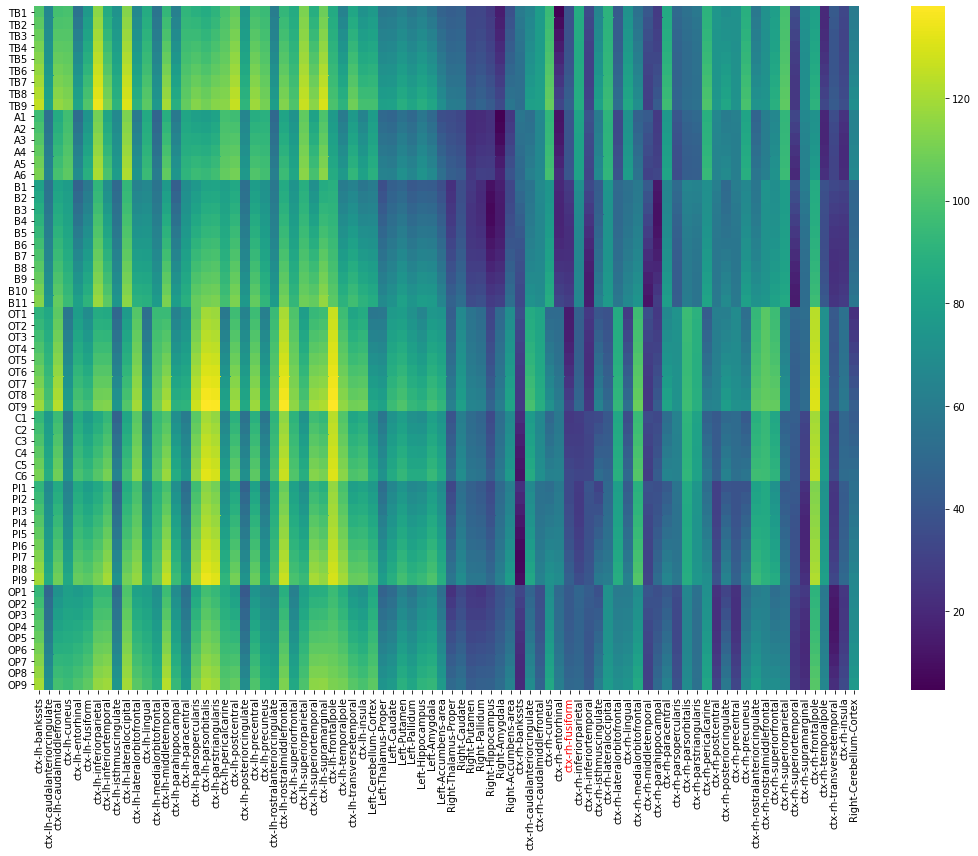

In [22]:
# get the pairwise distnaces of the channels and regions
region_pos = conn.centres

print(region_pos.shape, ch_xyz.shape)
ch_region_pdist = scipy.spatial.distance.cdist(ch_xyz, region_pos)
print(ch_region_pdist.shape)

fig, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(ch_region_pdist, cmap='viridis', 
            yticklabels=ch_names,
            xticklabels=conn.region_labels, ax=ax)
# plot resected region as red
for label in ax.get_xticklabels():
    if any([ezreg in label.get_text() for ezreg in ez_label]):
        print(label)
        label.set_color('red')
fig.tight_layout()

Text(0, 0, 'OT1') [['OT1']] 14.507025155075729
Text(1, 0, 'OT2') [['OT2']] 14.719986781583733
Text(2, 0, 'OT3') [['OT3']] 15.728414250966306
Text(3, 0, 'OT4') [['OT4']] 17.3939822596782
Text(4, 0, 'OT5') [['OT5']] 19.556481913933293
done


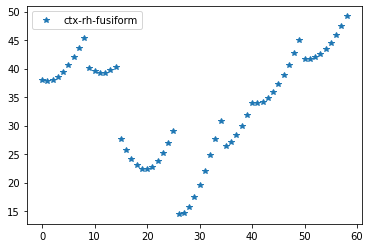

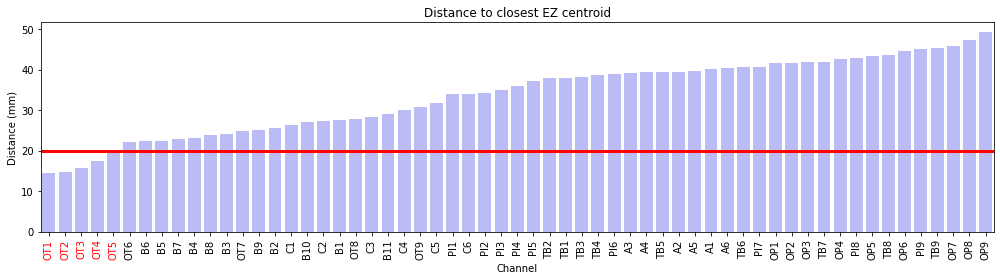

In [23]:
# keep track of resected channels
resected_chs = []

ezinds = [idx for idx, label in enumerate(conn.region_labels) if label in ez_label]

ezdists = ch_region_pdist[:, ezinds].copy()
order = np.argsort(ezdists.min(axis=1))

fig, ax = plt.subplots()
for idx in range(len(ezinds)):
    x = np.arange(len(ch_names))
    y = ezdists[:, idx]
    label = ez_label[idx]
    ax.plot(x, y, '*', label=label)
ax.legend()

fig, ax = plt.subplots(figsize=(14, 4))
colors = ['blue', 'yellow']
for idx in range(len(ezinds)):
    x = ch_names
    y = ezdists[:, idx]
    color = colors[idx]
    sns.barplot(x, y, ax=ax, 
                color=color,
                alpha=0.3,
                order=x[order])
    
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.axhline(20, label='Resection threshold', lw=3, color='red')
# plot resected region as red
for label in ax.get_xticklabels():
    ch_name = label.get_text()
    ch_ind = np.argwhere(ch_names == ch_name)
    dists = ezdists[ch_ind, :]
    if dists.min() < 20:
        resected_chs.append(ch_name)
        print(label, ch_names[ch_ind], dists.min())
        label.set_color('red')
ax.set(
    title='Distance to closest EZ centroid',
    ylabel='Distance (mm)',
    xlabel='Channel'
)
fig.tight_layout()
print('done')

## Get Stable Initial Conditions

In [609]:
from tvb.simulator.models.epileptor import Epileptor
from tvb.simulator.models.epileptor_rs import EpileptorRestingState
from tvb.simulator.lab import cortex, local_connectivity

In [610]:
sim = setup_simulation(
    conn, ch_xyz, gain_fname=str(gain_inv_fname),
    ezind=ezhypo_inds,
    pzind=pzhypo_inds,
    seeg_fname=ch_xyz_fpath,
    variables_of_interest=['x1', 'y1', 'z', 'x2', 'y2', 'g', 'x2 - x1'],
    r=0.00035 / 10, tt=0.75
)

[<tvb.simulator.monitors.TemporalAverage object at 0x13b5ed2e0>, <tvb.simulator.monitors.iEEG object at 0x13895a670>]


In [611]:
(times, epilepts), (_, seegts) = sim.run(simulation_length=10000)

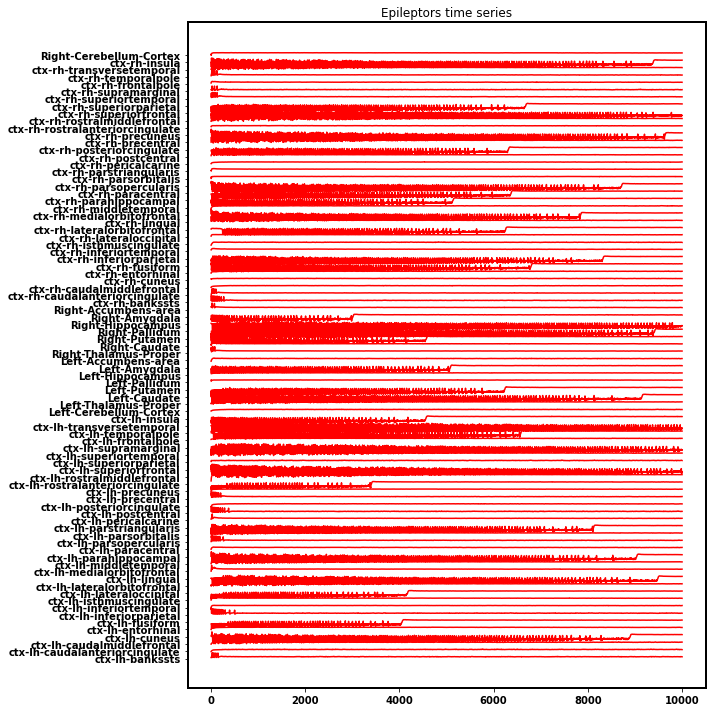

In [612]:
#Plot raw time series
plt.figure(figsize=(10,10))
plt.plot(times[:], epilepts[:, -1, :, 0] / (np.max(epilepts[:, -1, :, 0].max(axis=0))) + np.r_[:len(conn.region_labels)], 'r')
plt.title("Epileptors time series")
plt.yticks(np.r_[:nregions], conn.region_labels[:nregions])
plt.tight_layout()
plt.show()

In [613]:
# note that there are now 7 state variables
# the first 6 are part of the Epileptor fast/slow/veryslow subsystems 
# the last 1 is the actual time series that is projected to the sEEG electrode locations
print(epilepts.shape)

(10000, 7, 84, 1)


In [614]:
# we store the initial conditions as a 6x1 array
initial_conditions = epilepts[-1, :-1, :, :][np.newaxis, ...]

# re-run simulation and check that initial conditions worked
sim = setup_simulation(
    conn, ch_xyz, gain_fname=str(gain_inv_fname),
    ezind=ezhypo_inds, pzind=pzhypo_inds,
    seeg_fname=ch_xyz_fpath,
    variables_of_interest=['x1', 'y1', 'z', 'x2', 'y2', 'g', 'x2 - x1'],
    r=0.00035 / 10, tt=0.75, initial_conditions=initial_conditions,
#     resected_chs=resected_chs
)

(times, epilepts), (_, seegts) = sim.run(simulation_length=15000)

[<tvb.simulator.monitors.TemporalAverage object at 0x1387d5c10>, <tvb.simulator.monitors.iEEG object at 0x1386c5d30>]


In [615]:
# make sure subject doesn't have '_' character
subject = subject.replace('_', '')
print(subject)

# create a file path to save initial conditions to
bids_path = BIDSPath(subject=subject, session='preresection', 
                     task='initialconditionswithfrontal', 
                     suffix='epileptor',
                     extension='.npy', check=False)
initial_cond_fpath = output_path / bids_path.basename

id008gc


In [619]:
# save initial conditions into a numpy array
np.save(initial_cond_fpath, initial_conditions)
print(f'Saved initial conditions to: {initial_cond_fpath}')

Saved initial conditions to: /Users/adam2392/OneDrive - Johns Hopkins/sickkids/derivatives/tvb/sub-id008gc_ses-preresection_task-initialconditionswithfrontal_epileptor.npy


In [617]:
initial_conditions = epilepts[2100, :-1, ...][np.newaxis, ...]
print(initial_conditions.shape)

(1, 6, 84, 1)


In [620]:
initial_conditions = np.load(initial_cond_fpath)
print(initial_conditions.shape)

(1, 6, 84, 1)


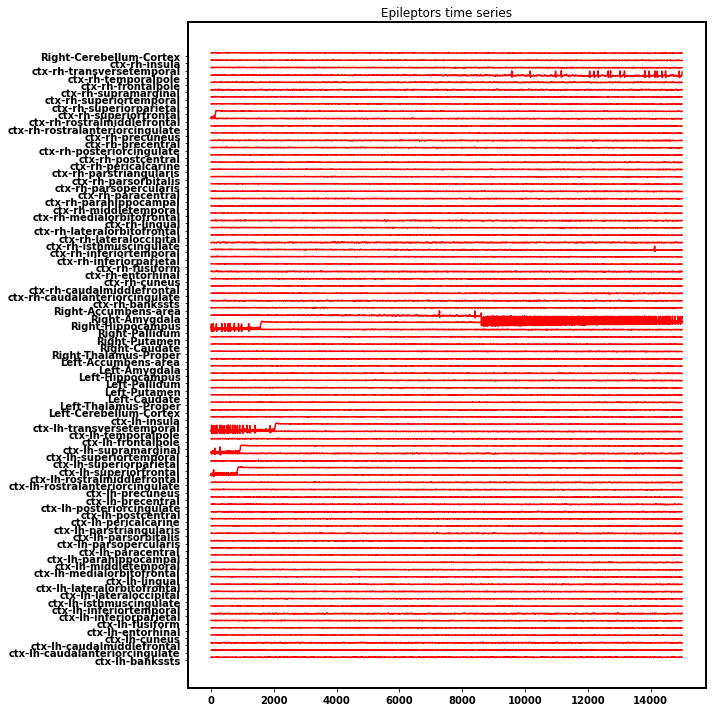

In [616]:
#Plot raw time series
plt.figure(figsize=(10,10))
plt.plot(times[:], epilepts[:, -1, :, 0] / (np.max(epilepts[:, -1, :, 0].max(axis=0))) + np.r_[:len(conn.region_labels)], 'r')
plt.title("Epileptors time series")
plt.yticks(np.r_[:nregions], conn.region_labels[:nregions])
plt.tight_layout()
plt.show()

# Setup Final Simulation Object

In [621]:
print(ezhypo_inds, pzhypo_inds)

(array([46, 47]),) (array([56, 80]),)


In [622]:
sim = setup_simulation(
    conn, ch_xyz, gain_fname=str(gain_inv_fname),
    ezind=ezhypo_inds, pzind=pzhypo_inds,
    seeg_fname=ch_xyz_fpath,
    initial_conditions=initial_conditions,
#     x0norm=-2.40, 
    r=0.00035 / 10, tt=0.75,
#     pzind=pzhypo_inds,
)

[<tvb.simulator.monitors.TemporalAverage object at 0x1385b1670>, <tvb.simulator.monitors.iEEG object at 0x1392ae670>]


In [623]:
print(sim)

Simulator (
  Type ................................ Simulator
  conduction_speed .................... 3.0
  connectivity ........................ Connectivity gid: 41ac11db-a64f-4a86-a271-1325d689ee9f
  coupling ............................ Difference gid: 902a6d61-6745-47f9-93b2-ee08ade998c3
  gid ................................. UUID('d0f3be0c-5e8f-4318-abb2-b63769e2ddbe')
  initial_conditions [min, median, max]  [-18.7724, -0.488896, 4.05029]
  initial_conditions dtype ............ float64
  initial_conditions shape ............ (1, 6, 84, 1)
  integrator .......................... HeunStochastic gid: afa6723e-f808-4449-b837-c45ae4f99375
  model ............................... Epileptor gid: 186d783b-7ae2-4243-8bf2-4463deac2741
  monitors ............................ [<tvb.simulator.monitors.TemporalAverage object at 0x1385b1670>, <tvb.simulator.monitors.iEEG object at 0x1392ae670>]
  simulation_length ................... 1000.0
  stimulus ............................ None
  surfac

# Run Simulation

In [624]:
sim_length = 30000
(times, epilepts), (_, seegts) = sim.run(
        simulation_length=sim_length)

In [625]:
seeg = seegts.copy()
tavg = epilepts.copy()

In [626]:
# Normalize the time series to have nice plots
tavg /= (np.max(tavg,0) - np.min(tavg,0 ))
seeg /= (np.max(seeg,0) - np.min(seeg, 0))
seeg -= np.mean(seeg, 0)

In [627]:
print(len(conn.region_labels))
print(epilepts.shape)
print(epilepts[:, 0, :, 0].max(axis=0).shape)

84
(30000, 2, 84, 1)
(84,)


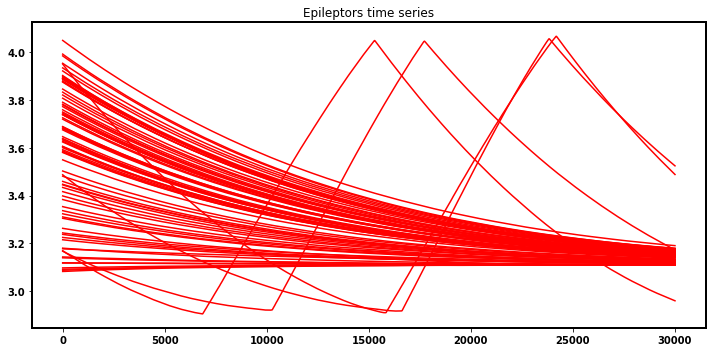

In [628]:
#Plot raw time series
plt.figure(figsize=(10,5))
plt.plot(times[:], epilepts[:, 0, :, 0]
#          + np.r_[:len(conn.region_labels)]
         , 'r')
plt.title("Epileptors time series")
# plt.yticks(np.r_[:nregions], conn.region_labels[:nregions])
plt.tight_layout()
plt.show()



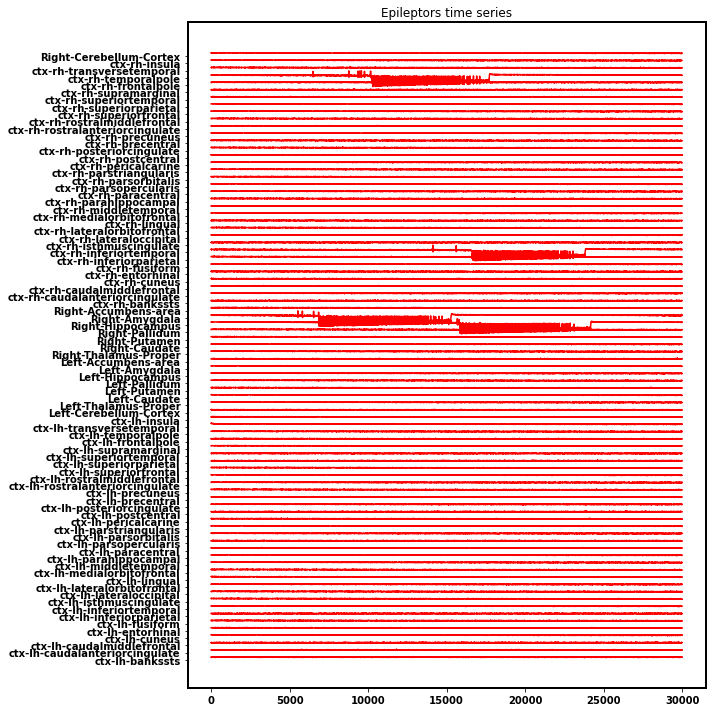

In [629]:
#Plot raw time series
plt.figure(figsize=(10,10))
plt.plot(times[:], epilepts[:, 1, :, 0] / (np.max(epilepts[:, 1, :, 0].max(axis=0))) + np.r_[:len(conn.region_labels)], 'r')
plt.title("Epileptors time series")
plt.yticks(np.r_[:nregions], conn.region_labels[:nregions])
plt.tight_layout()
plt.show()

['R1' 'R2' 'R3' 'R4' 'R5' 'R6' 'R7' 'R8' 'R9' 'R10' 'R11' 'CR1' 'CR2'
 'CR3' 'CR4' 'CR5' 'CR6' 'CR7' 'CR8' 'CR9' 'CR10' 'CR11' 'FD1' 'FD2' 'FD3'
 'FD4' 'FD5' 'FD6' 'FD7' 'FD8' 'FD9' 'FD10' 'FD11' 'CC1' 'CC2' 'CC3' 'CC4'
 'CC5' 'CC6' 'CC7' 'CC8' 'CC9' 'CC10' 'CC11' 'TP1' 'TP2' 'TP3' 'TP4' 'TP5'
 'TP6' 'A1' 'A2' 'A3' 'A4' 'A5' 'A6' 'A7' 'A8' 'A9' 'A10' 'A11' 'A12'
 'A13' 'B1' 'B2' 'B3' 'B4' 'B5' 'B6' 'B7' 'B8' 'B9' 'B10' 'B11' 'B12'
 'B13' 'GPH1' 'GPH2' 'GPH3' 'GPH4' 'GPH5' 'GPH6' 'GPH7' 'GPH8' 'GPH9'
 'GPH10' 'GPH11' 'GPH12' 'T1' 'T2' 'T3' 'T4' 'OR1' 'OR2' 'OR3' 'OR4' 'OR5'
 'OR6' 'OR7' 'OR8' 'OR9' 'OR10' 'OR11']


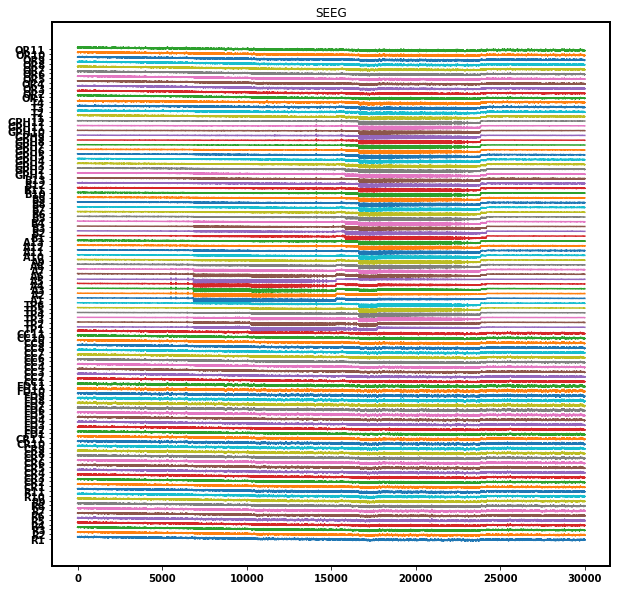

In [630]:
plt.figure(figsize=(10,10))
plt.plot(times[:], seeg[:,0, :len(ch_names), 0] + np.r_[:len(ch_names)])
plt.yticks(np.r_[:len(ch_names)], ch_names[:len(ch_names)])
plt.title("SEEG")

print(ch_names)

In [631]:
# make sure subject doesn't have '_' character
subject = subject.replace('_', '')
print(subject)

# save data and the sEEG projections
bids_path = BIDSPath(subject=subject, session='extraoperative', 
                     task='tvbsimezpz', suffix='ieeg', run='01',
                     extension='.npz', check=False)
print(bids_path.basename)

id008gc
sub-id008gc_ses-extraoperative_task-tvbsimezpz_run-01_ieeg.npz


In [632]:
np.savez_compressed(output_path / bids_path.basename, 
                   epilepts=epilepts, seegts=seegts, 
                    times=times,
                   ch_names=ch_names, region_names=conn.region_labels)

## Fragility analysis of the original data

In [633]:
data_dict = np.load(output_path / bids_path.basename, allow_pickle=True)

epilepts = data_dict['epilepts']
seeg = data_dict['seegts']
ch_names = data_dict['ch_names']
region_names = data_dict['region_names']

In [634]:
seegdata = seeg[:, 0, ...].squeeze().T / 1e6
print(seegdata.shape)

info = create_info(sfreq=1000., ch_names=ch_names.tolist(), ch_types='seeg')
raw = RawArray(seegdata, info=info)

(103, 30000)


In [635]:
raw.drop_channels(raw.info['bads'])
raw.pick_types(seeg=True, ecog=True)
raw.load_data()
print(raw)

l_freq = 0.5
h_freq = 200
line_freq = 60
nyq_freq = 300 # raw.info['sfreq'] // 2
freqs = np.arange(line_freq, max(h_freq, nyq_freq), line_freq)
raw.filter(l_freq=l_freq, h_freq=h_freq)

raw = raw.notch_filter(freqs, method='fir')

<RawArray | 103 x 30000 (30.0 s), ~23.8 MB, data loaded>


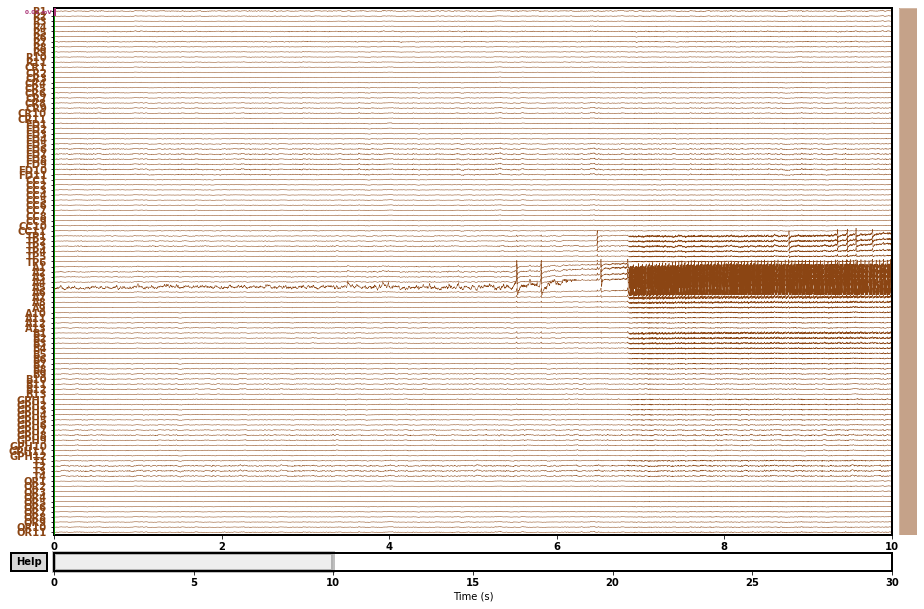

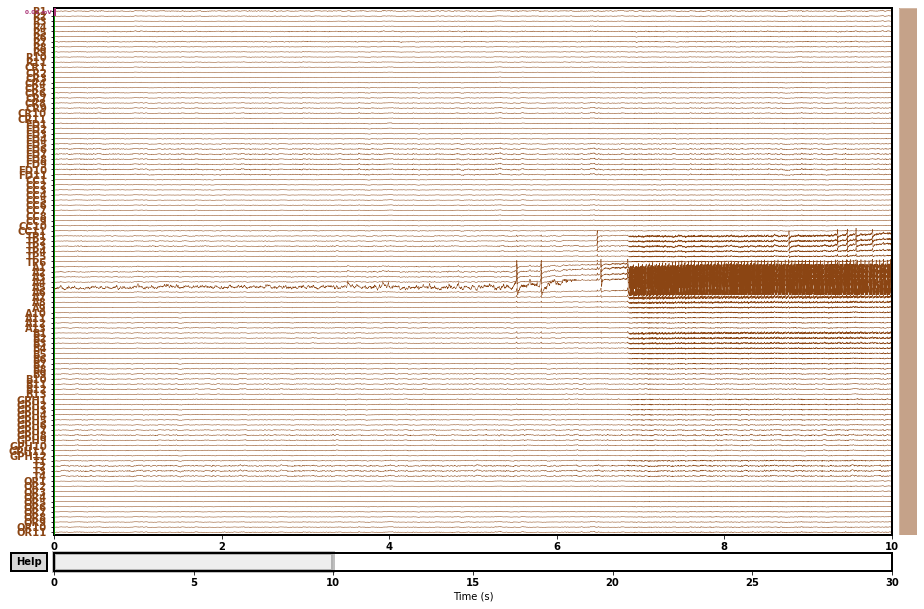

In [636]:
raw.plot(scalings={'seeg': 1e-5}, n_channels=103)

<ipython-input-637-a5fcf744740b>:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd()


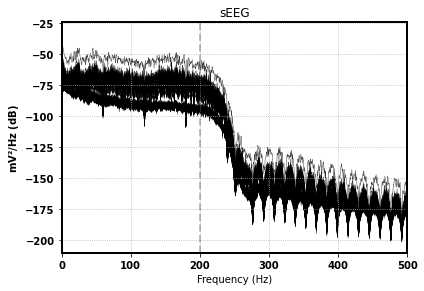

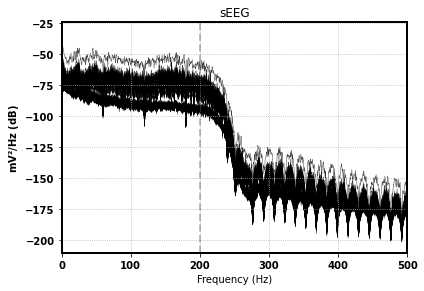

In [637]:
raw.plot_psd()

In [638]:
pert_deriv, state_deriv, deltavecs_deriv = lds_raw_fragility(
    raw, reference='monopolar', return_all=True, order=1,
    l2penalty=1e-9, 
    radius=3.0,
    method_to_use='fbpinv',
)

Fragility Heatmap:   0%|          | 0/239 [00:00<?, ?eeg window/s]

Using fbpinv least squares with l2penalty 1e-09.
Data matrix shape input: (103, 30000). Estimate state array with LTI Window Model | order=1, l2_penalty=1e-09, svd_rank=0.95 and compute perturbation with Structured Perturbation Model | radius=3.0, perturb_type=C.


Fragility Heatmap: 100%|██████████| 239/239 [00:30<00:00,  7.81eeg window/s]


(103,) (103, 103) (103, 103)


/Users/adam2392/Documents/eztrack/eztrack/fragility/fragility.py:747: ComplexWarning: Casting complex values to real discards the imaginary part
  A_mats[..., i] = adjmat
/Users/adam2392/Documents/sickkids/.venv/lib/python3.8/site-packages/numpy/core/_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


(<Figure size 1800x1483.2 with 2 Axes>, <AxesSubplot:xlabel='Time (Secs)'>)

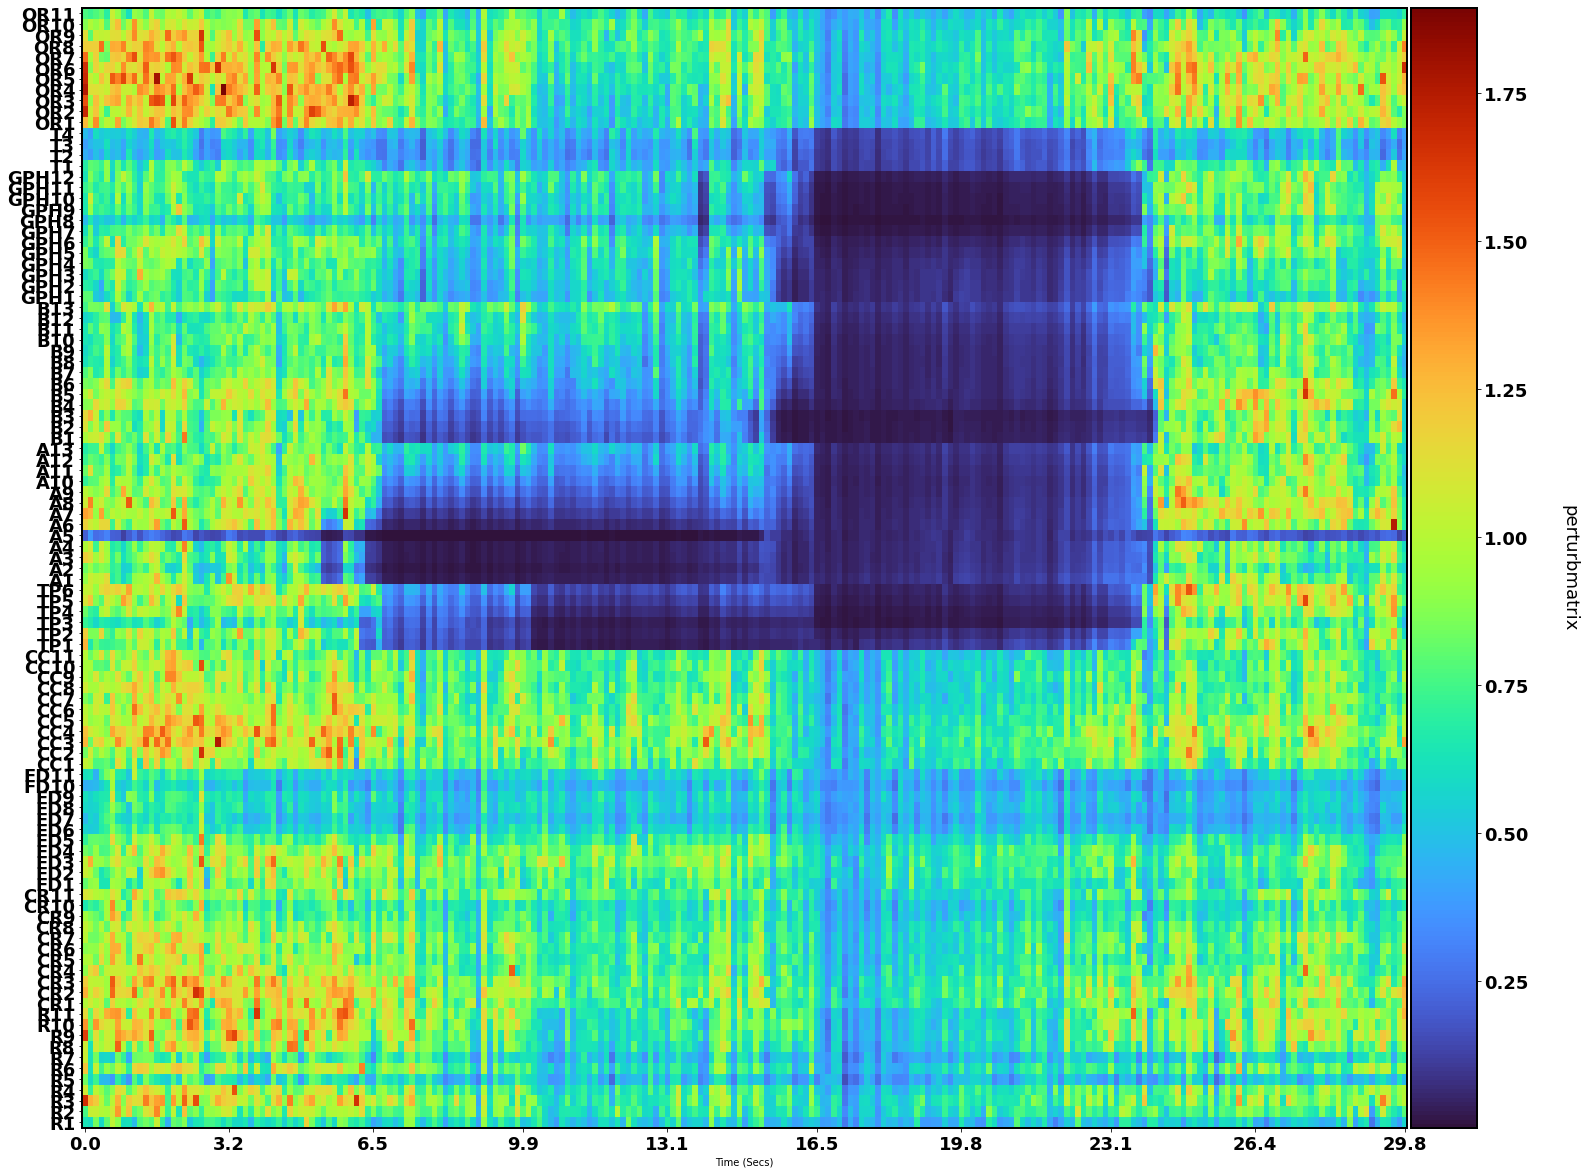

In [639]:
pert_deriv.plot_heatmap()

<DerivativeArray | None, shape: (103, 239) (103 chs x 239 times) (29.8 s), ~386 kB, data loaded | reference=monopolar | perturbmatrix>


(<Figure size 1800x1483.2 with 2 Axes>, <AxesSubplot:xlabel='Time (Secs)'>)

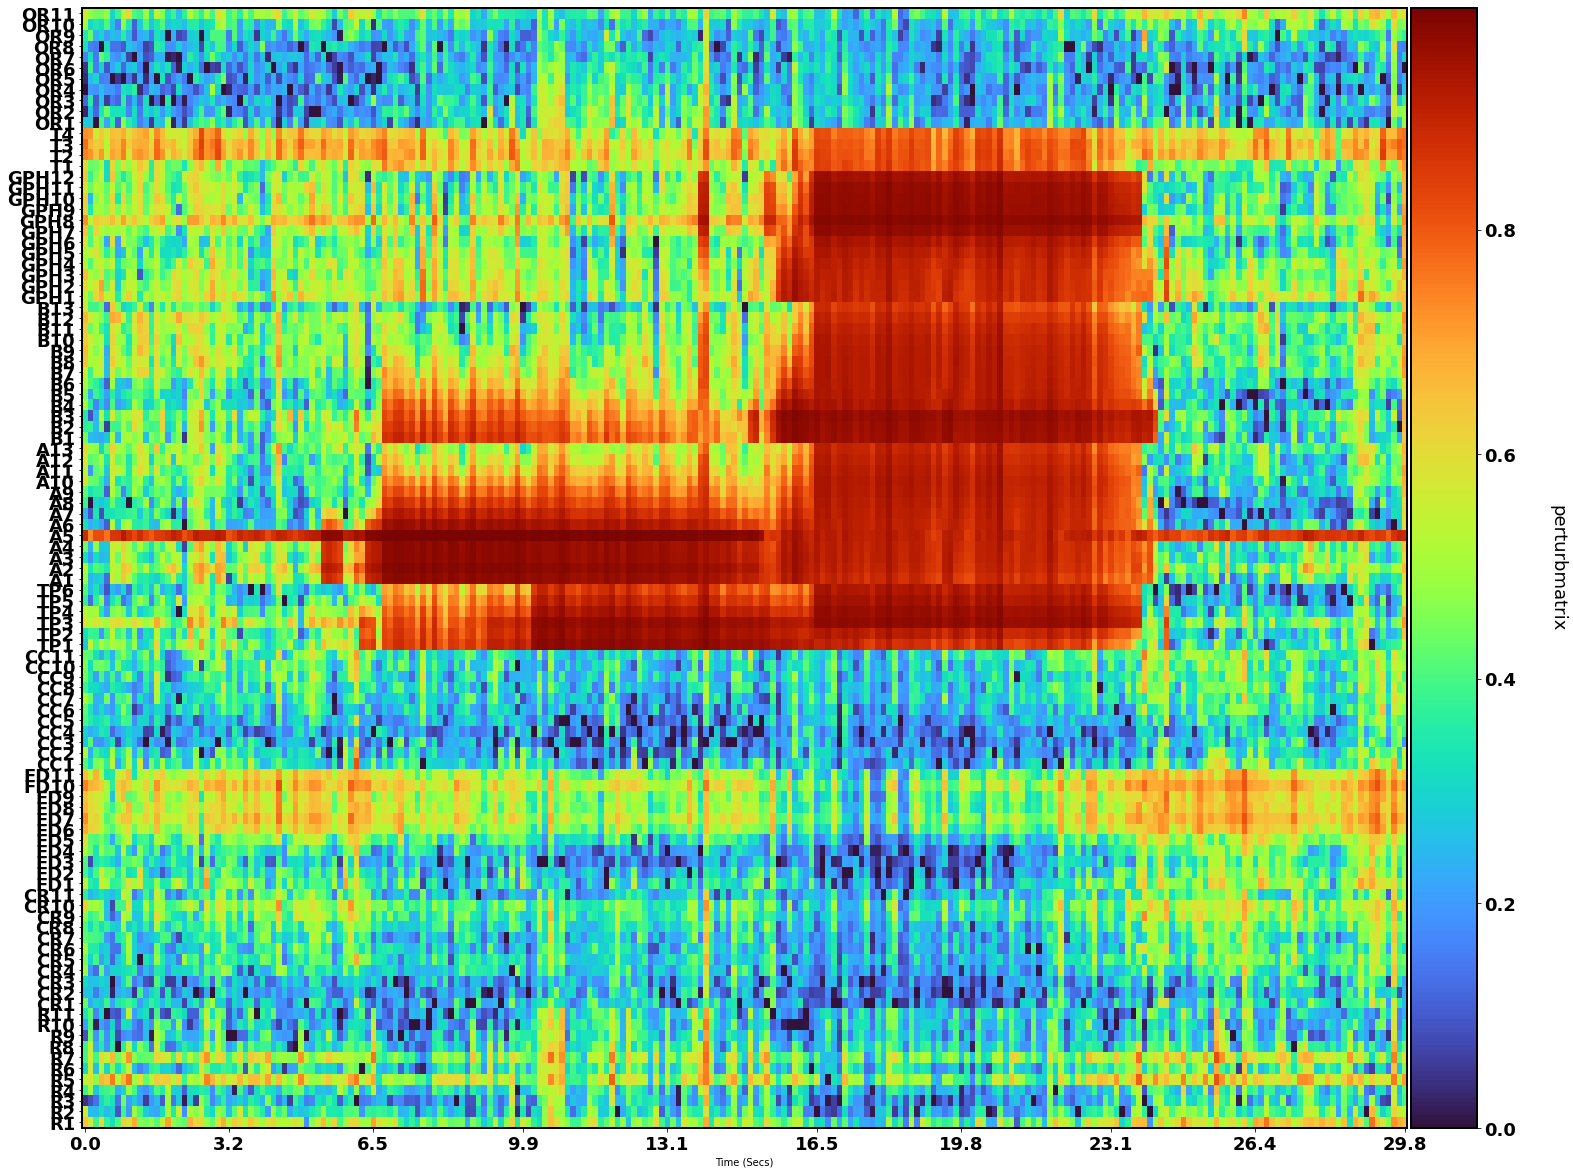

In [640]:
pert_deriv.normalize()

pert_deriv.plot_heatmap()

# Modeling the Surgical Resection

In [641]:
if subject == 'id013pg':
    ez_label = ['ctx-rh-fusiform', 
#                 'Right-Hippocampus', 'Right-Amygdala'
               ]
    pz_label = ['Right-Hippocampus', 'Right-Amygdala', 
#                 'ctx-rh-middltemporal', 
                'ctx-rh-inferiortemporal',
#                 'ctx-rh-entorhinal'
               ] 
elif subject == 'id008gc':
    ez_label = ['Right-Amygdala', 'Right-Hippocampus', 
#                                'ctx-rh-medialorbitofrontal'
               ]
    pz_label = [
#         'ctx-rh-superiortemporal', 
#                 'ctx-rh-middletemporal', 
                'ctx-rh-inferiortemporal', 
                'ctx-rh-temporalpole',
#                 'ctx-rh-lateralorbitofrontal'
               ]
else:
    ez_label = None
    pz_label = None

In [642]:
# read in the ez hypothesis regions
with open(subj_path / 'tvb' / 'ez_hypothesis.txt', 'r') as fin:
    ez_hypo = pd.read_csv(fin, delimiter='\n').to_numpy().squeeze()
print(ez_hypo)
ezhypo_inds = ez_hypo[np.argwhere(ez_hypo == 1)]

# get the hypothesized EZ and PZ
ezhypo_inds = np.where(np.in1d(conn.region_labels, ez_label))
ez_regions = conn.region_labels[ezhypo_inds]

pzhypo_inds = np.where(np.in1d(conn.region_labels, pz_label))
pz_regions = conn.region_labels[pzhypo_inds]

print(ez_regions, pz_regions)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 0]
['Right-Hippocampus' 'Right-Amygdala'] ['ctx-rh-inferiortemporal' 'ctx-rh-temporalpole']


In [643]:
print(ezhypo_inds)
print(ez_regions)
print(pzhypo_inds)
print(pz_regions)

(array([46, 47]),)
['Right-Hippocampus' 'Right-Amygdala']
(array([56, 80]),)
['ctx-rh-inferiortemporal' 'ctx-rh-temporalpole']


In [644]:
conn = resect_regions(conn, ezhypo_inds)
conn = resect_regions(conn, pzhypo_inds)
print(conn.summary_info())

{'Number of regions': 84, 'Number of connections': 6918, 'Undirected': True, 'areas shape': '(84,)', 'areas dtype': 'float64', 'areas [min, median, max]': '[299.64, 1983.88, 13628.8]', 'weights shape': '(84, 84)', 'weights dtype': 'float64', 'weights [min, median, max]': '[0, 0.000209165, 1]', 'weights-non-zero [min, median, max]': '[3.37363e-06, 0.000307, 1]', 'tract_lengths [min, median, max]': '[0, 117.422, 196.851]', 'tract_lengths-non-zero [min, median, max]': '[13.338, 118.306, 196.851]', 'tract_lengths (connections) [min, median, max]': '[13.338, 118.797, 196.851]'}


<ipython-input-645-42e25eb72286>:4: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(conn.weights), interpolation='nearest', aspect='equal', cmap='viridis')


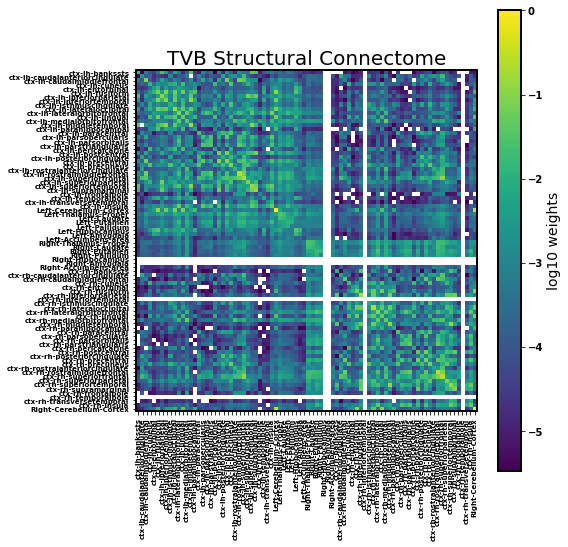

In [645]:
nregions = len(conn.region_labels)
# Visualization.
plt.figure(figsize=(8,8))
plt.imshow(np.log10(conn.weights), interpolation='nearest', aspect='equal', cmap='viridis')
plt.title('TVB Structural Connectome', fontsize=20)
plt.xticks(range(0, nregions), conn.region_labels, fontsize=7, rotation=90)
plt.yticks(range(0, nregions), conn.region_labels, fontsize=7)
cb=plt.colorbar(
#     shrink=0.8
)
cb.set_label('log10 weights', fontsize=14)
plt.tight_layout()
plt.show()

In [646]:
print(bids_path)
# load the location of each electrodes
electrodes_path = bids_path.copy().update(
    root=root, task=None, run=None, suffix='electrodes', 
    session='extraoperative',
    acquisition='seeg', space='mri', extension='.tsv')

elec_df = pd.read_csv(electrodes_path, delimiter='\t')
display(elec_df.head())

elec_names = elec_df.name.tolist()
elec_regions = elec_df['desikan-killiany'].tolist()

print(elec_names)
# resected channels
resected_chs = [ch for idx, ch in enumerate(elec_names) if elec_regions[idx] in ez_label]
pz_resected_chs =  [ch for idx, ch in enumerate(elec_names) if elec_regions[idx] in pz_label]
resected_chs.extend(pz_resected_chs)
print('Resected these channels: ', resected_chs)

sub-id008gc/ses-extraoperative/ieeg/sub-id008gc_ses-extraoperative_task-tvbsimezpz_run-01_ieeg.npz


name     x      y     z  size             desikan-killiany
0   R1 -5.98  56.97  6.70   NaN   ctx-rh-medialorbitofrontal
1   R2 -2.49  57.24  6.82   NaN   ctx-rh-medialorbitofrontal
2   R3  1.00  57.51  6.94   NaN   ctx-rh-medialorbitofrontal
3   R4  4.48  57.78  7.06   NaN  ctx-rh-lateralorbitofrontal
4   R5  7.97  58.05  7.19   NaN  ctx-rh-lateralorbitofrontal

['R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R9', 'R10', 'R11', 'R12', 'CR1', 'CR2', 'CR3', 'CR4', 'CR5', 'CR6', 'CR7', 'CR8', 'CR9', 'CR10', 'CR11', 'CR12', 'FD1', 'FD2', 'FD3', 'FD4', 'FD5', 'FD6', 'FD7', 'FD8', 'FD9', 'FD10', 'FD11', 'FD12', 'CC1', 'CC2', 'CC3', 'CC4', 'CC5', 'CC6', 'CC7', 'CC8', 'CC9', 'CC10', 'CC11', 'CC12', 'OR1', 'OR2', 'OR3', 'OR4', 'OR5', 'OR6', 'OR7', 'OR8', 'OR9', 'OR10', 'OR11', 'OR12', 'TP1', 'TP2', 'TP3', 'TP4', 'TP5', 'TP6', 'TP7', 'TP8', 'TP9', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B13', 'B14', 'GPH1', 'GPH2', 'GPH3', 'GPH4', 'GPH5', 'GPH6', 'GPH7', 'GPH8', 'GPH9', 'GPH10', 'GPH11', 'GPH12', 'GPH13', 'T1', 'T2', 'T3', 'T4', 'T5', 'ECG', 'EMG1', 'EMG2']
Resected these channels:  ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'B1', 'B2', 'B3', 'B4', 'TP1', 'TP3', 'TP4', 'TP5', 'TP6', 'B5', 'GPH7', 'GPH8', 'GPH9', 'GPH10', 'GPH11'

In [548]:
ez_label = ['ctx-rh-medialorbitofrontal']
pz_label = ['ctx-rh-lateralorbitofrontal']
# get the hypothesized EZ and PZ
ezhypo_inds = np.where(np.in1d(conn.region_labels, ez_label))
ez_regions = conn.region_labels[ezhypo_inds]

pzhypo_inds = np.where(np.in1d(conn.region_labels, pz_label))
pz_regions = conn.region_labels[pzhypo_inds]


In [647]:
# and re-save it as a temporary file
seeg_pd = pd.read_csv(ch_xyz_fpath, names=['x', 'y', 'z'], delim_whitespace=True)

# load in the gain file and remove the indices
ch_names = seeg_pd.index
seeg_pd.drop(resected_chs, inplace=True)

# resave the dataframe
# new_seeg_fname = os.path.join(temp_path, os.path.basename(seeg_fname))
# seeg_pd.to_csv('./test.txt', sep=' ', columns=None, header=False)

In [648]:
sim = setup_simulation(
    conn, ch_xyz, gain_fname=str(gain_inv_fname),
#     ezind=ezhypo_inds, pzind=pzhypo_inds,
    seeg_fname=ch_xyz_fpath,
    initial_conditions=initial_conditions,
#     x0norm=-2.40, 
    r=0.00035 / 10, tt=0.75,
    resected_chs=resected_chs
)

[<tvb.simulator.monitors.TemporalAverage object at 0x13bbaf430>, <tvb.simulator.monitors.iEEG object at 0x13bb85490>]


In [649]:
sim_length = 30000
(times, epilepts), (_, seegts) = sim.run(
        simulation_length=sim_length)

In [650]:
seeg = seegts
tavg = epilepts

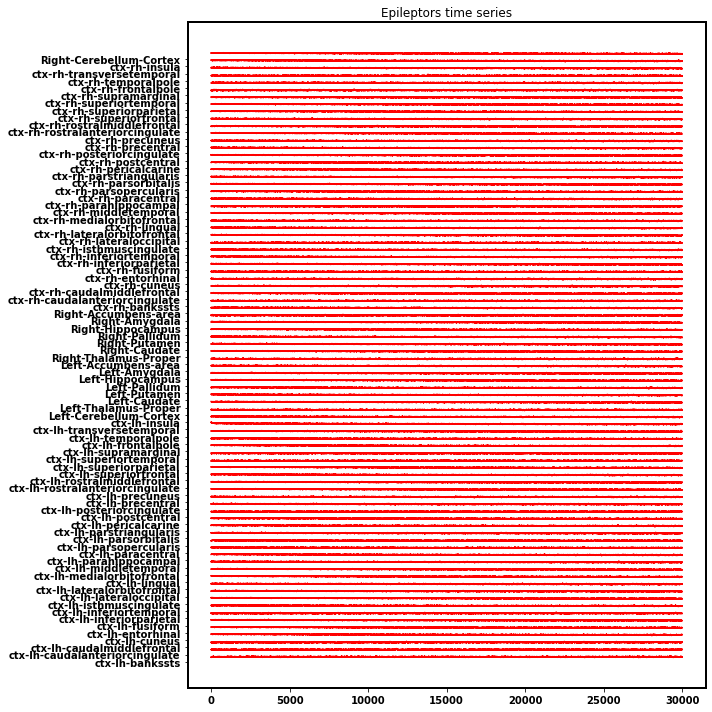

In [651]:
#Plot raw time series
plt.figure(figsize=(10,10))
plt.plot(times[:], epilepts[:, 1, :, 0] / (np.max(epilepts[:, 1, :, 0].max(axis=0))) + np.r_[:len(conn.region_labels)], 'r')
plt.title("Epileptors time series")
plt.yticks(np.r_[:nregions], conn.region_labels[:nregions])
plt.tight_layout()
plt.show()

In [652]:
resected_ch_names = [ch for ch in ch_names if ch not in resected_chs]
print(len(resected_ch_names))

80


Index(['R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R9', 'R10',
       ...
       'OR2', 'OR3', 'OR4', 'OR5', 'OR6', 'OR7', 'OR8', 'OR9', 'OR10', 'OR11'],
      dtype='object', length=103)


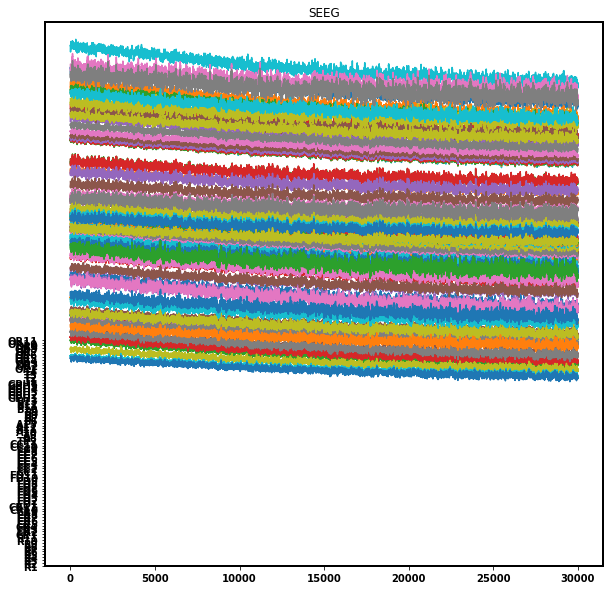

In [653]:
plt.figure(figsize=(10,10))
plt.plot(times[:], seeg[:,0, :len(resected_ch_names), 0]  + np.r_[:len(resected_ch_names)])
plt.yticks(np.r_[:len(resected_ch_names)], resected_ch_names[:len(resected_ch_names)])
plt.title("SEEG")

print(ch_names)

In [655]:
# make sure subject doesn't have '_' character
subject = subject.replace('_', '')
print(subject)

# save data and the sEEG projections
bids_path = BIDSPath(subject=subject, session='postresection', 
                     task='tvbsimezpz', suffix='ieeg', run='01',
                     extension='.npz', check=False)
print(bids_path.basename)

id008gc
sub-id008gc_ses-postresection_task-tvbsimezpz_run-01_ieeg.npz


In [656]:
np.savez_compressed(output_path / bids_path.basename, 
                   epilepts=epilepts, seegts=seegts, 
                    times=times,
                   ch_names=resected_ch_names, region_names=conn.region_labels)

## Fragility analysis of the resected data

In [560]:
seegdata = seeg[:, 0, ...].squeeze().T / 1e5
print(seegdata.shape)

info = create_info(sfreq=1000., ch_names=resected_ch_names, ch_types='seeg')
raw = RawArray(seegdata, info=info)

(80, 30000)


In [561]:
raw.drop_channels(raw.info['bads'])
raw.pick_types(seeg=True, ecog=True)
raw.load_data()
print(raw)

l_freq = 0.5
h_freq = 200
line_freq = 60
nyq_freq = 300 # raw.info['sfreq'] // 2
freqs = np.arange(line_freq, max(h_freq, nyq_freq), line_freq)
raw.filter(l_freq=l_freq, h_freq=h_freq)

raw = raw.notch_filter(freqs, method='fir')

<RawArray | 80 x 30000 (30.0 s), ~18.5 MB, data loaded>


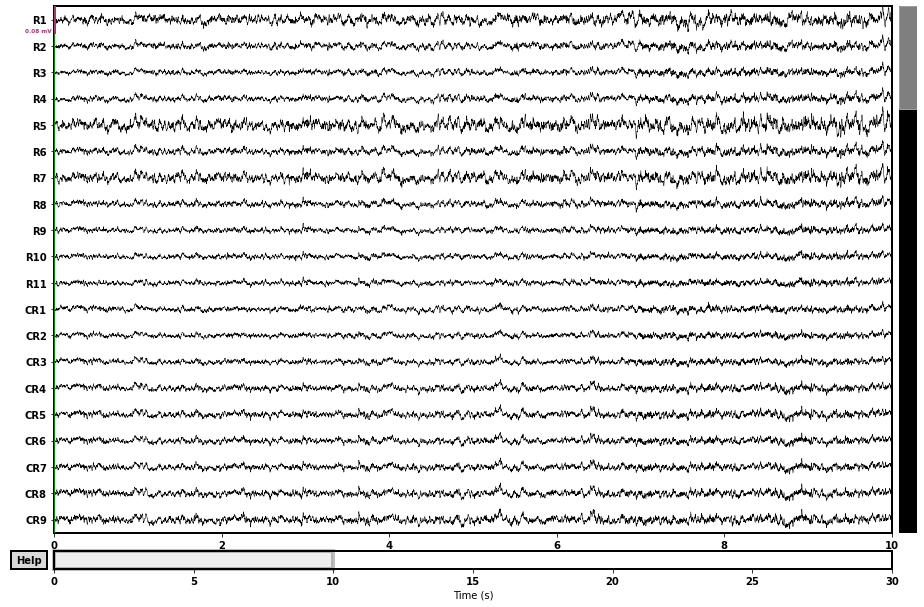

<ipython-input-584-64ea058f796b>:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd()


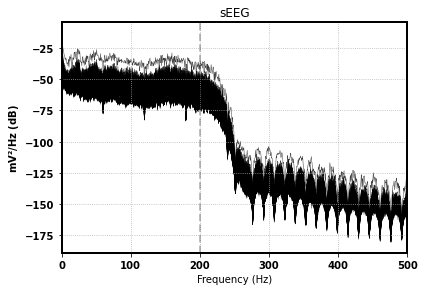

done


In [584]:
raw.plot(scalings={'seeg': 4e-5}, color='black')

raw.plot_psd()

print('done')

In [563]:
pert_deriv, state_deriv, deltavecs_deriv = lds_raw_fragility(
    raw, reference='monopolar', method_to_use='fbpinv', 
    l2penalty=1e-5,
    radius=3.0,
    return_all=True)

Fragility Heatmap:   0%|          | 0/239 [00:00<?, ?eeg window/s]

Using fbpinv least squares with l2penalty 1e-05.
Data matrix shape input: (80, 30000). Estimate state array with LTI Window Model | order=1, l2_penalty=1e-05, svd_rank=0.95 and compute perturbation with Structured Perturbation Model | radius=3.0, perturb_type=C.


Fragility Heatmap: 100%|██████████| 239/239 [00:15<00:00, 15.74eeg window/s]


(80,) (80, 80) (80, 80)


/Users/adam2392/Documents/eztrack/eztrack/fragility/fragility.py:747: ComplexWarning: Casting complex values to real discards the imaginary part
  A_mats[..., i] = adjmat
/Users/adam2392/Documents/sickkids/.venv/lib/python3.8/site-packages/numpy/core/_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


(<Figure size 1800x1800 with 2 Axes>, <AxesSubplot:xlabel='Time (Secs)'>)

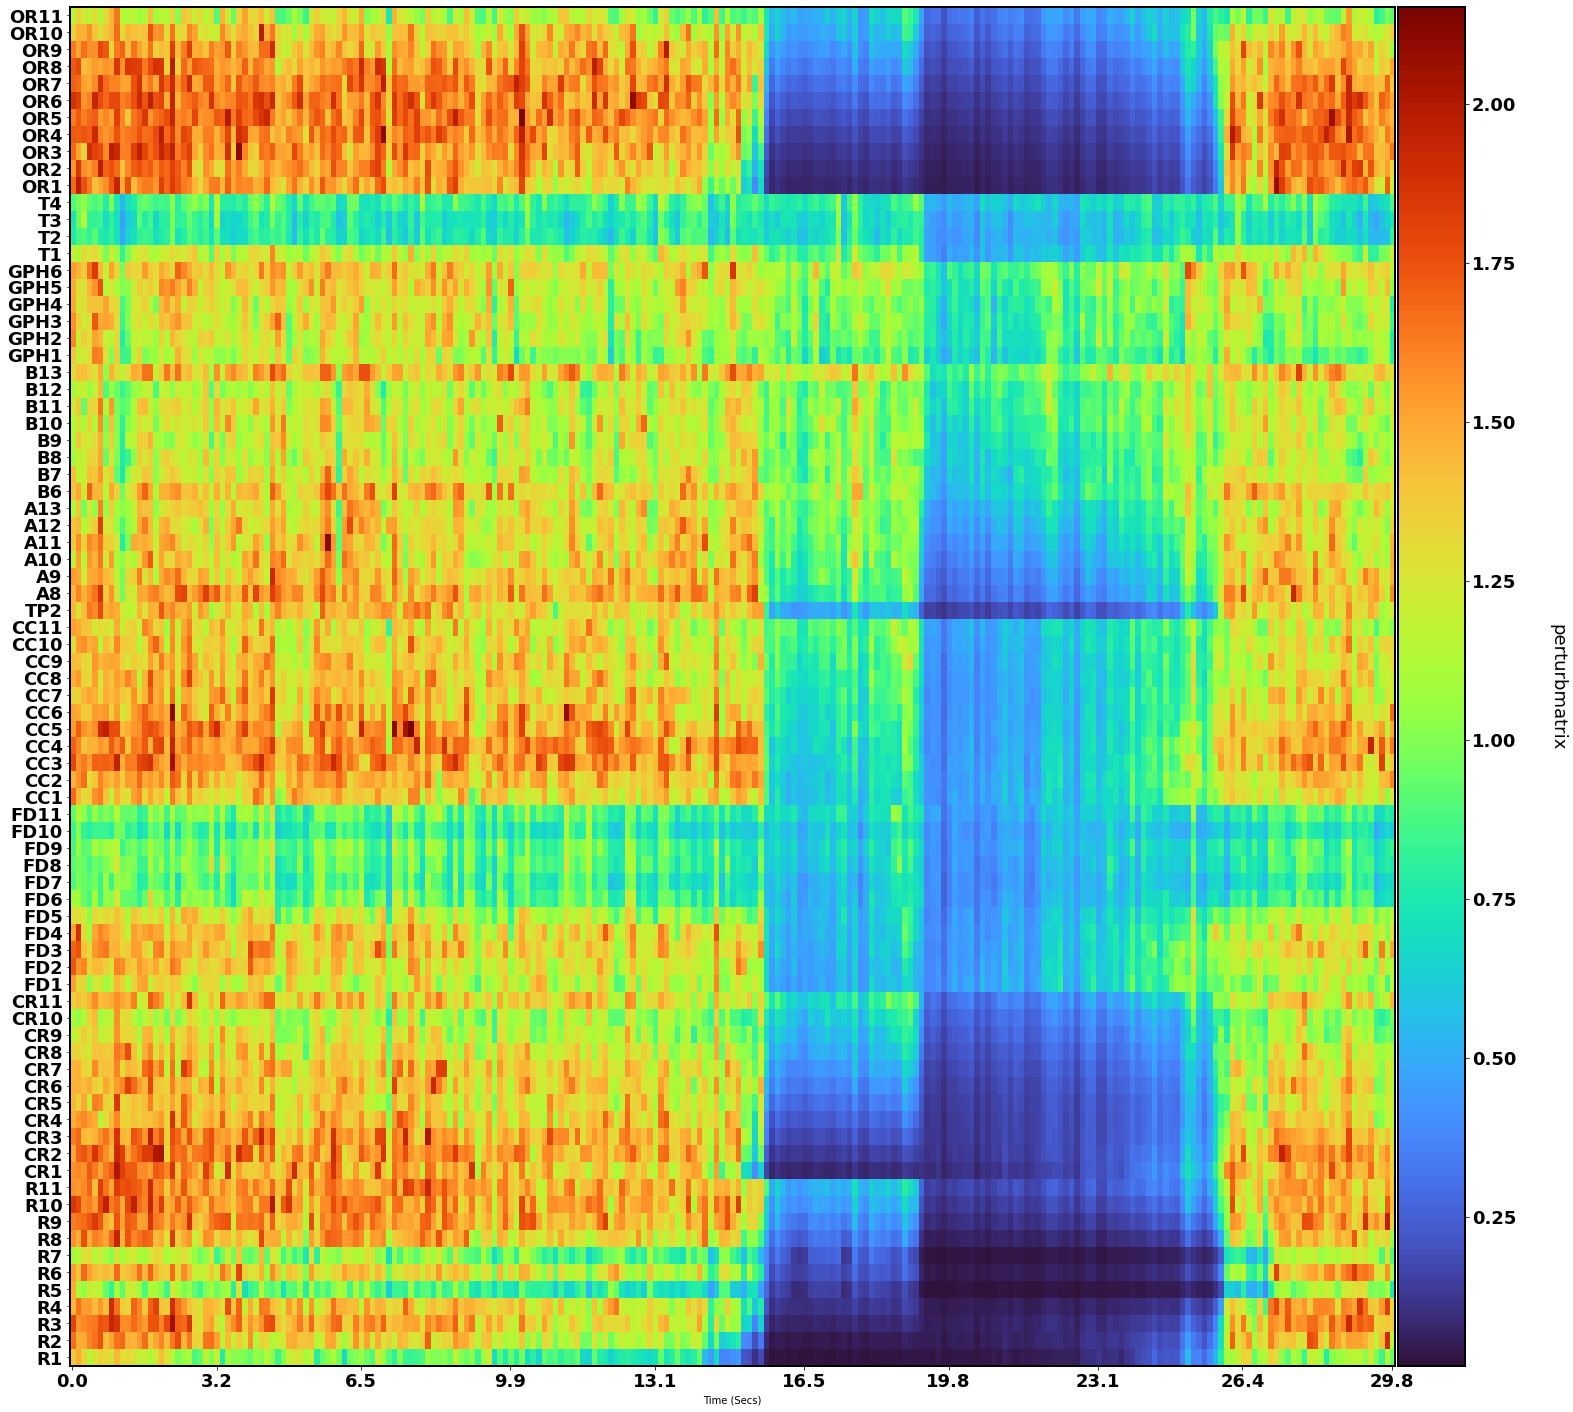

In [564]:
pert_deriv.plot_heatmap()

<DerivativeArray | None, shape: (80, 239) (80 chs x 239 times) (29.8 s), ~302 kB, data loaded | reference=monopolar | perturbmatrix>


(<Figure size 1800x1800 with 2 Axes>, <AxesSubplot:xlabel='Time (Secs)'>)

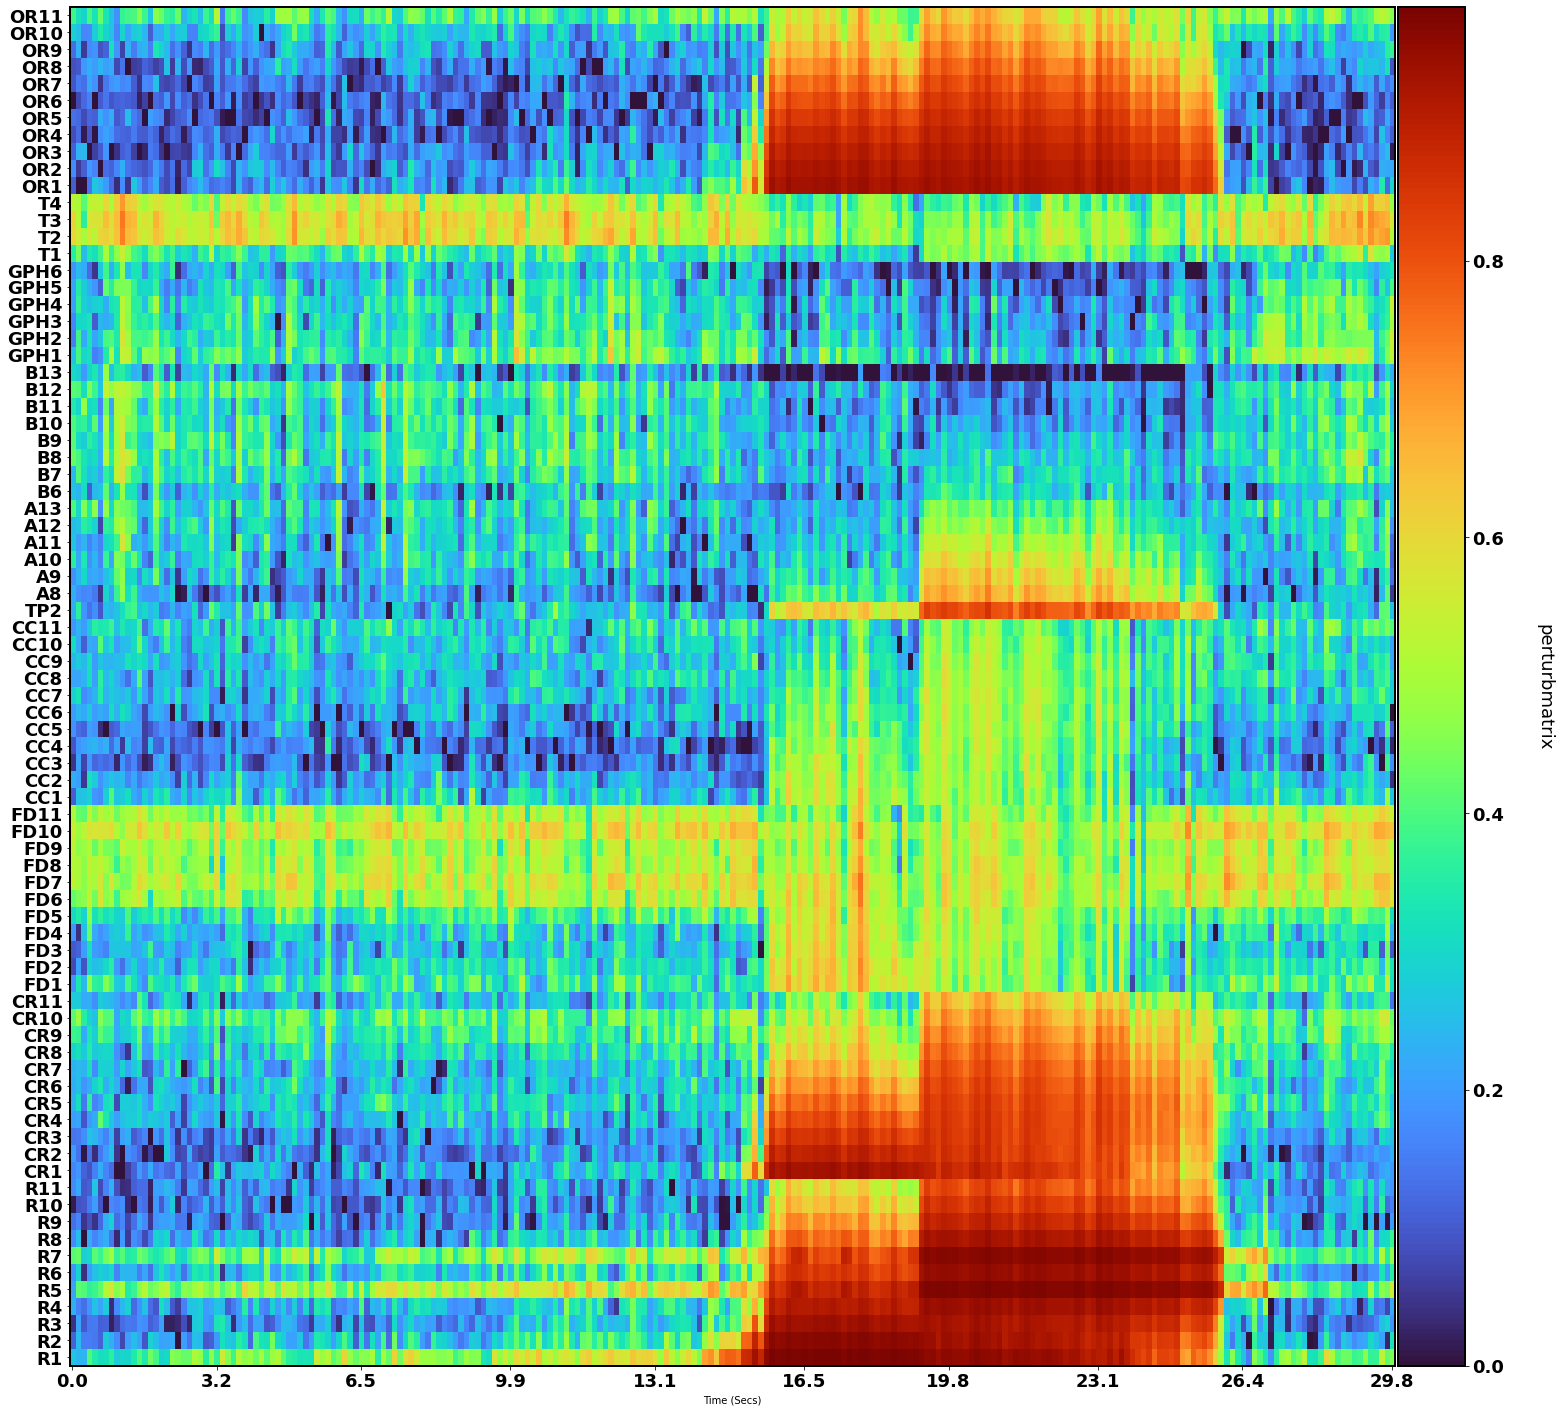

In [565]:
pert_deriv.normalize()

pert_deriv.plot_heatmap()

# Comparing the Before/After Resection Using Fragility

In [567]:
bids_path = BIDSPath(subject=subject, session='postresection', 
                     task='tvbsimezpz', suffix='ieeg', run='02',
                     extension='.npz', check=False)
print(bids_path.basename)

data_dict = np.load(output_path / bids_path.basename, allow_pickle=True)

# load in the resected data
resected_seeg_ts = data_dict['seegts']
resected_ch_names = data_dict['ch_names']

print(resected_seeg_ts.shape, resected_ch_names.shape)

sub-id008gc_ses-postresection_task-tvbsimezpz_run-02_ieeg.npz
(30000, 1, 80, 1) (80,)


In [568]:
bids_path = BIDSPath(subject=subject, session='extraoperative', 
                     task='tvbsimezpz', suffix='ieeg', run='02',
                     extension='.npz', check=False)
print(bids_path.basename)

data_dict = np.load(output_path / bids_path.basename, allow_pickle=True)

# load in the resected data
seeg_ts = data_dict['seegts']
ch_names = data_dict['ch_names']

sub-id008gc_ses-extraoperative_task-tvbsimezpz_run-02_ieeg.npz


In [569]:
seegdata = resected_seeg_ts[:, 0, ...].squeeze().T / 1e5
print(seegdata.shape)

info = create_info(sfreq=1000., ch_names=list(resected_ch_names), ch_types='seeg')
resected_raw = RawArray(seegdata, info=info)

resected_raw.drop_channels(raw.info['bads'])
resected_raw.pick_types(seeg=True, ecog=True)
resected_raw.load_data()
print(resected_raw)

l_freq = 0.5
h_freq = 200
line_freq = 60
nyq_freq = 300 # raw.info['sfreq'] // 2
freqs = np.arange(line_freq, max(h_freq, nyq_freq), line_freq)
resected_raw.filter(l_freq=l_freq, h_freq=h_freq)

resected_raw = resected_raw.notch_filter(freqs, method='fir')

(80, 30000)
<RawArray | 80 x 30000 (30.0 s), ~18.5 MB, data loaded>


In [570]:
seegdata = seeg_ts[:, 0, ...].squeeze().T / 1e5
print(seegdata.shape)

info = create_info(sfreq=1000., ch_names=list(ch_names), ch_types='seeg')
raw = RawArray(seegdata, info=info)

raw.drop_channels(raw.info['bads'])
raw.pick_types(seeg=True, ecog=True)
raw.load_data()
print(raw)

l_freq = 0.5
h_freq = 200
line_freq = 60
nyq_freq = 300 # raw.info['sfreq'] // 2
freqs = np.arange(line_freq, max(h_freq, nyq_freq), line_freq)
raw.filter(l_freq=l_freq, h_freq=h_freq)

raw = raw.notch_filter(freqs, method='fir')

(103, 30000)
<RawArray | 103 x 30000 (30.0 s), ~23.8 MB, data loaded>


## Compute Fragility Maps For Each

In [571]:
pert_deriv, state_deriv, deltavecs_deriv = lds_raw_fragility(
    raw, reference='monopolar', method_to_use='fbpinv', 
    l2penalty=1e-5,
    radius=3.0,
    return_all=True)

Fragility Heatmap:   0%|          | 0/239 [00:00<?, ?eeg window/s]

Using fbpinv least squares with l2penalty 1e-05.
Data matrix shape input: (103, 30000). Estimate state array with LTI Window Model | order=1, l2_penalty=1e-05, svd_rank=0.95 and compute perturbation with Structured Perturbation Model | radius=3.0, perturb_type=C.


Fragility Heatmap: 100%|██████████| 239/239 [00:30<00:00,  7.89eeg window/s]


(103,) (103, 103) (103, 103)


In [572]:
resect_pert_deriv, _, _ = lds_raw_fragility(
    resected_raw, reference='monopolar', method_to_use='fbpinv', 
    l2penalty=1e-5,
    radius=3.0,
    return_all=True)

Fragility Heatmap:   0%|          | 0/239 [00:00<?, ?eeg window/s]

Using fbpinv least squares with l2penalty 1e-05.
Data matrix shape input: (80, 30000). Estimate state array with LTI Window Model | order=1, l2_penalty=1e-05, svd_rank=0.95 and compute perturbation with Structured Perturbation Model | radius=3.0, perturb_type=C.


Fragility Heatmap: 100%|██████████| 239/239 [00:12<00:00, 19.80eeg window/s]


(80,) (80, 80) (80, 80)


<DerivativeArray | None, shape: (103, 239) (103 chs x 239 times) (29.8 s), ~386 kB, data loaded | reference=monopolar | perturbmatrix>


(<Figure size 1800x1483.2 with 2 Axes>, <AxesSubplot:xlabel='Time (Secs)'>)

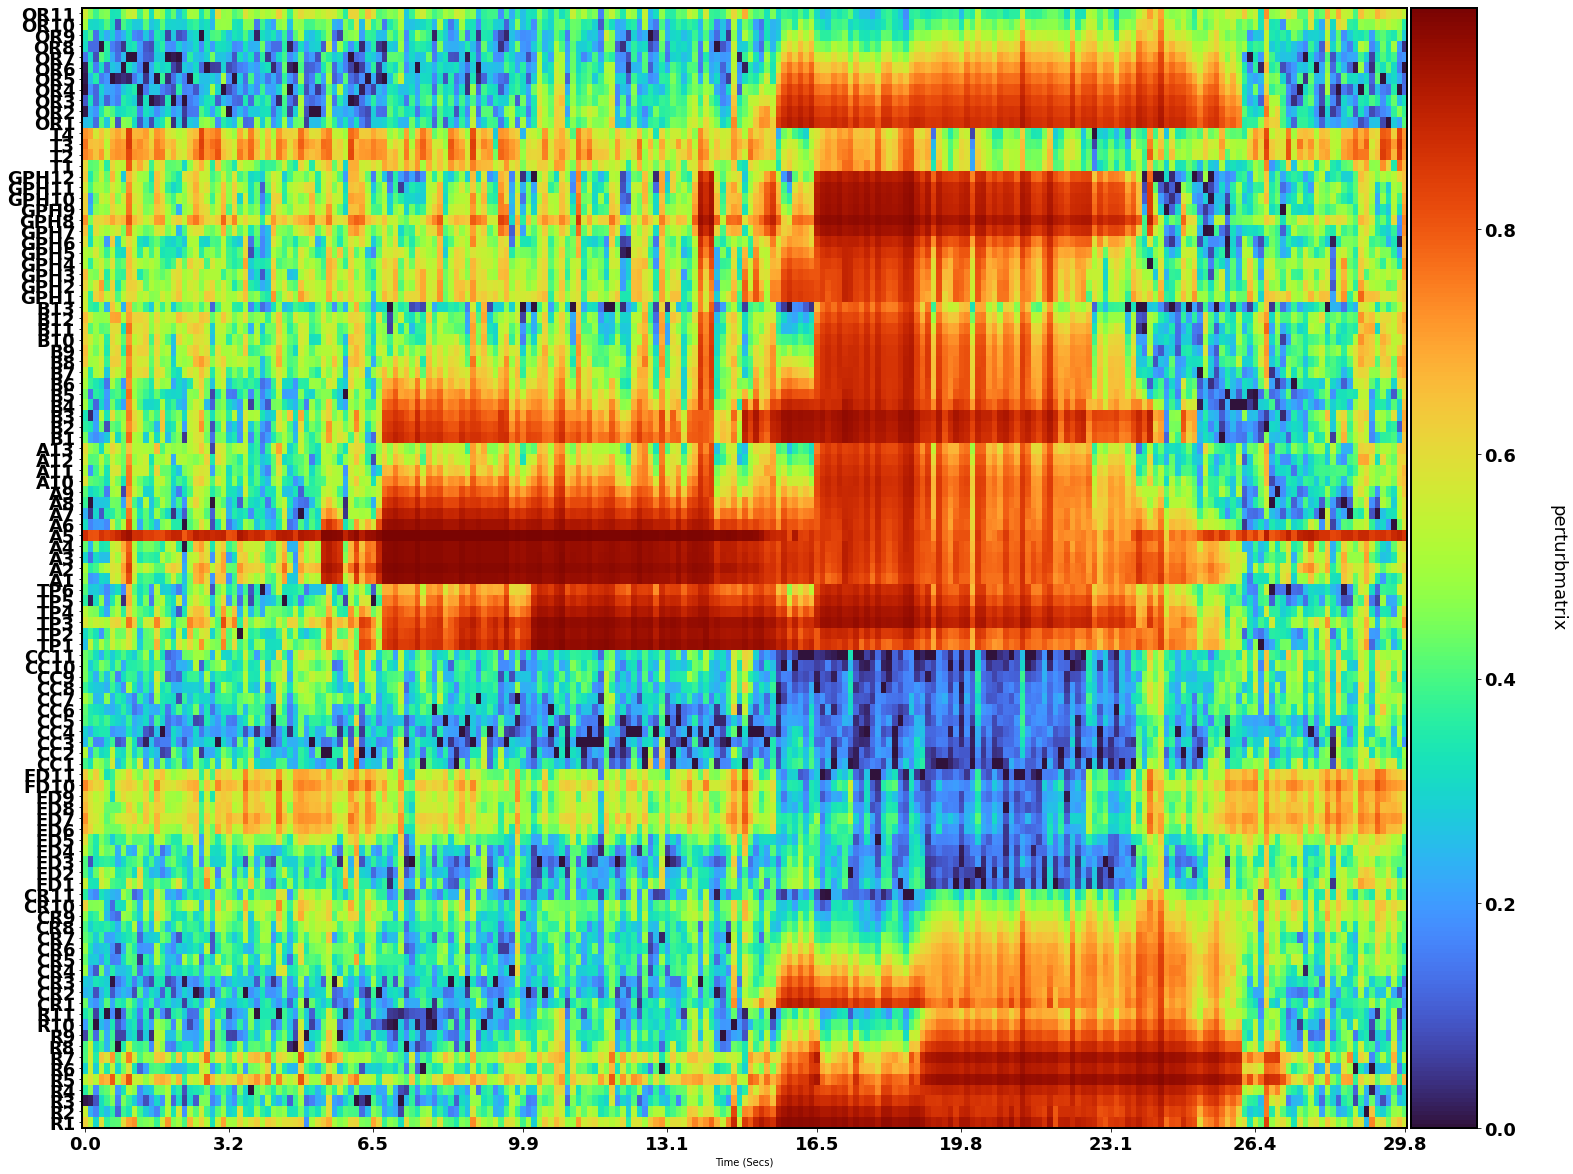

In [573]:
pert_deriv.normalize()

pert_deriv.plot_heatmap()

<DerivativeArray | None, shape: (80, 239) (80 chs x 239 times) (29.8 s), ~302 kB, data loaded | reference=monopolar | perturbmatrix>


(<Figure size 1800x1800 with 2 Axes>, <AxesSubplot:xlabel='Time (Secs)'>)

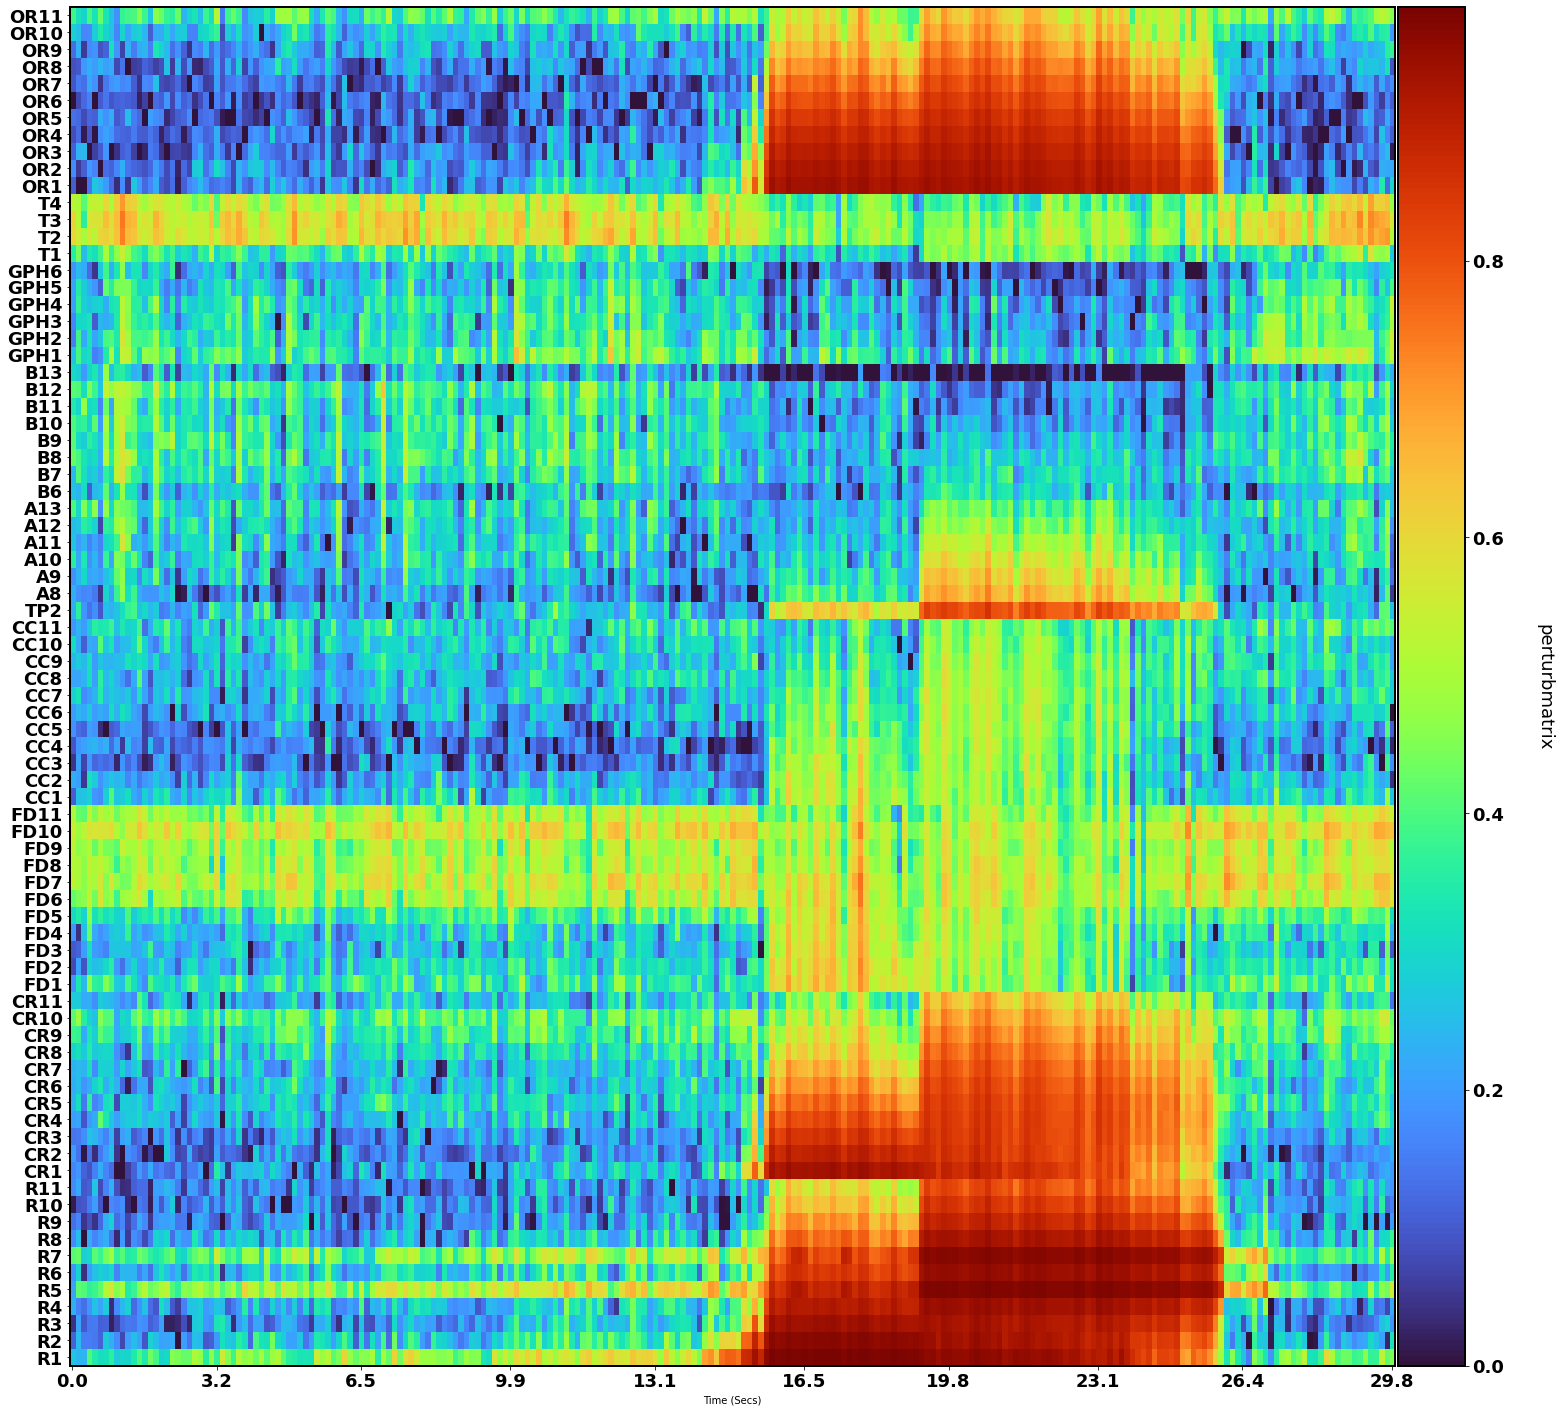

In [574]:
resect_pert_deriv.normalize()

resect_pert_deriv.plot_heatmap()

In [575]:
if not all([ch in resect_pert_deriv.ch_names for ch in pert_deriv.ch_names]):
    # get the set difference of channels
    add_chs = list(set(pert_deriv.ch_names) - set(resect_pert_deriv.ch_names))
    ch_type = pert_deriv.get_channel_types()[0]
    info = create_deriv_info(ch_names=add_chs, sfreq=pert_deriv.info['sfreq'], 
                             ch_types=ch_type, 
                             description=pert_deriv.description,
                            ch_axis=[0])
    addderiv = DerivativeArray(np.ones((len(add_chs), len(pert_deriv)))*-1, info=info, verbose=False)

    # add derivative chs
    resected_pert_deriv = resect_pert_deriv.add_channels([addderiv])
    
    resected_pert_deriv.reorder_channels(pert_deriv.ch_names)

derivs = [pert_deriv, resected_pert_deriv]
new_deriv = concatenate_derivs(derivs)

<DerivativeArray | None, shape: (23, 239) (23 chs x 239 times) (29.8 s), ~90 kB, data loaded | reference=None | perturbmatrix>
<DerivativeArray | None, shape: (80, 239) (80 chs x 239 times) (29.8 s), ~302 kB, data loaded | reference=monopolar | perturbmatrix>
<DerivativeArray | None, shape: (103, 239) (103 chs x 239 times) (29.8 s), ~385 kB, data loaded | reference=monopolar | perturbmatrix>


In [576]:
onsets = [len(pert_deriv), len(pert_deriv) + len(resect_pert_deriv)]
descriptions = ['extraoperative', 'postresection']


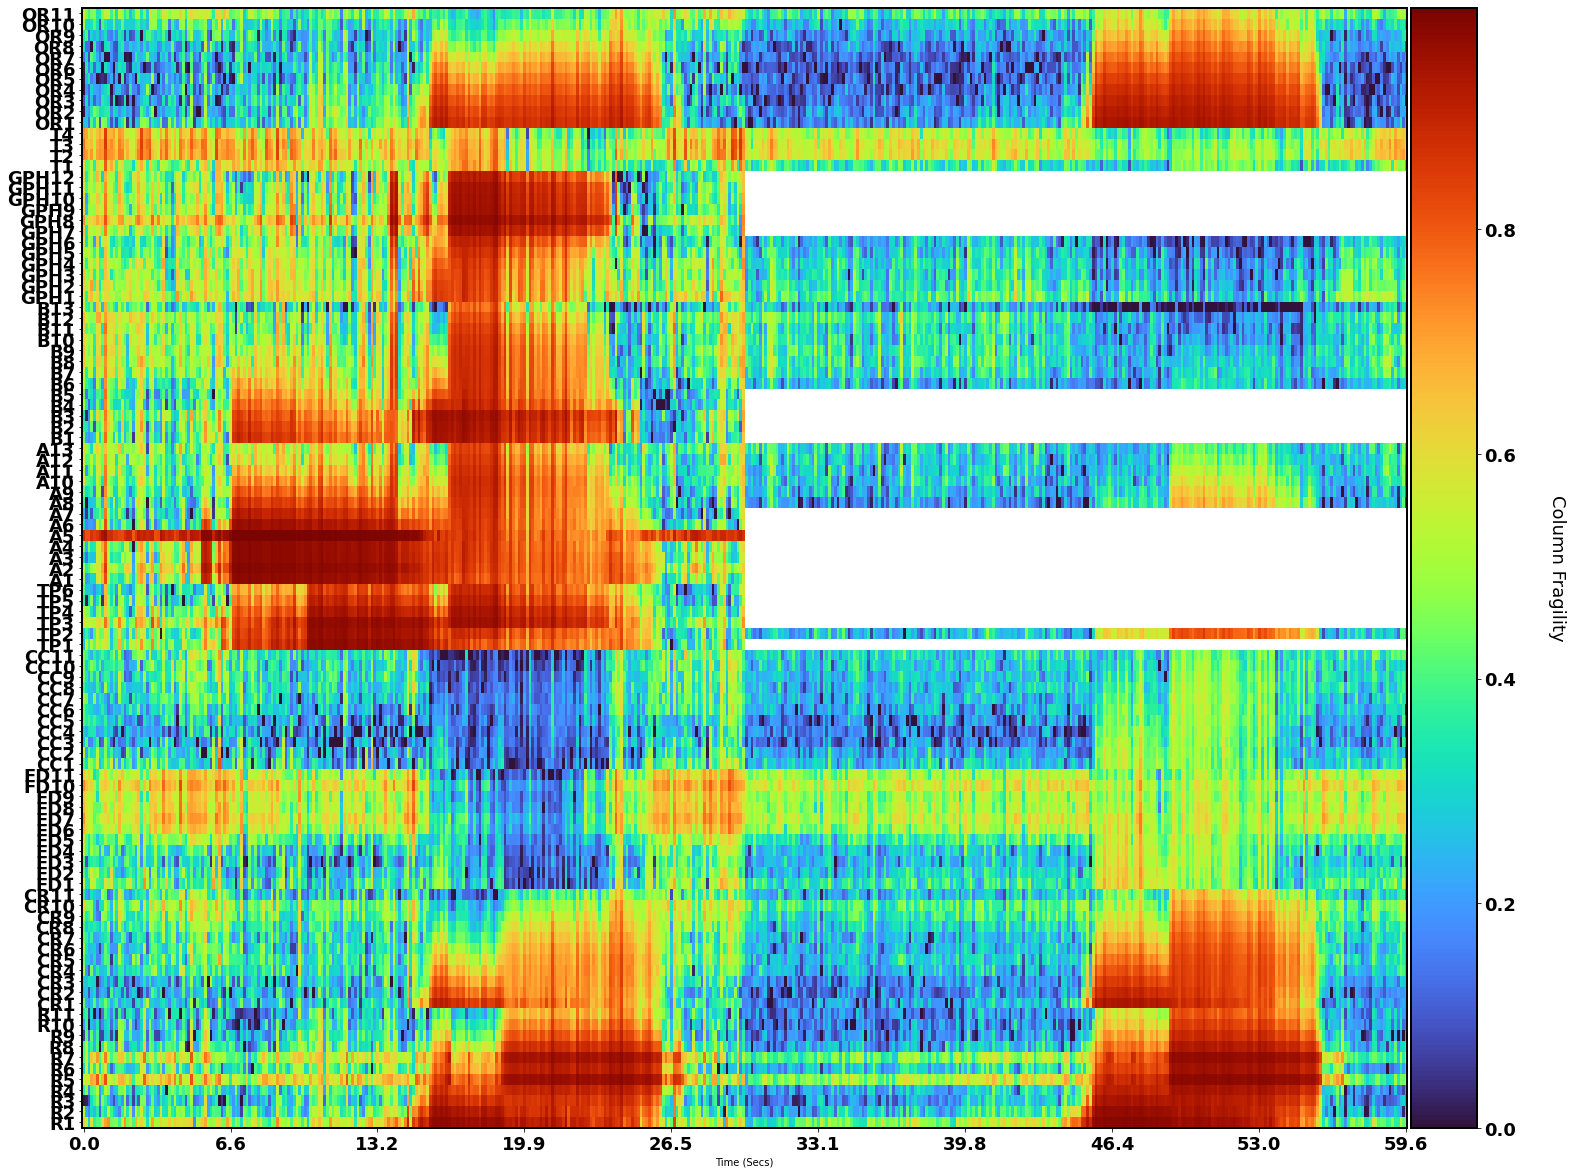

In [577]:
cbarlabel='Column Fragility'
fig, ax = new_deriv.plot_heatmap(vmin=0,
#                       soz_chs=resected_chs, 
                                 cbarlabel=cbarlabel,)

# colors = {'extraoperative': 'black',
# #           'preresection': 'white',
# #           'intraresection': 'gray',
#           'postresection': 'brown'}

# for onset, session in zip(onsets, descriptions):
# #     session = description.split('-')[1]
#     color = colors[session]
#     ax.axvline(onset, label=description, lw=5, color=color)
# ax.legend(loc=(1.04, 0))

fig_fname = output_path / 'figures' / f'{subject}-prepostresection.png'
fig_fname.parent.mkdir(exist_ok=True, parents=True)
fig.savefig(fig_fname)

## Compute Distribution Differences

In [585]:
def compute_mean_within_quantiles(data, quantile_values):
    n_qtiles, n_samps = quantile_values.shape
    
    # quantiles x time
    quantile_curves = np.zeros((n_qtiles, n_samps))
    
    # get the first one
    quantile_curves[0, :] = np.mean(
        np.ma.masked_array(
            data, mask=data>quantile_values[[0],:]), 
        axis=0
    )
    
    for q in range(n_qtiles - 1):
        # create a masked array of data that fall outside quantile range
        masked_arr = np.ma.masked_array(
            data, mask=np.logical_or(
                data < quantile_values[[q],:], data > quantile_values[[q+1],:])
        )
        
        # set as the mean of the masked array
        quantile_curves[q+1, :] = np.mean(masked_arr, axis=0)
    return quantile_curves

In [586]:
toplot_data = []

# create plot over the onsets
for deriv, description, onset in zip(derivs, descriptions, onsets):
    # get the data
    deriv_data = deriv.get_data()
    ch_names = np.array(deriv.ch_names)
    
    # apply mask
    mask = deriv_data[:, 0] != -1
    deriv_data = deriv_data[mask, :]
    ch_names = ch_names[mask]
    
    # get quantiles
    qranges = np.linspace(0.1, 1.0, 20)
    data_quantiles = np.quantile(deriv_data, axis=0, q=qranges)
#     print(data_quantiles.shape)
    
    # compute mean within quantiles
    qtile_means = compute_mean_within_quantiles(deriv_data, data_quantiles)
    
    toplot_data.append(qtile_means)
    
toplot_data = np.hstack(toplot_data)
print(toplot_data.shape)

(20, 717)


In [587]:
print(descriptions)

['extraoperative', 'postresection']


In [588]:
session_dict = collections.defaultdict(list)
session_names = []
data = []

prevonset = 0
for onset, description in zip(onsets, descriptions):
    if 'extraoperative' in description:
        key = description
#     elif 'ses-preresection' in description:
#         key = 'ses-preresection'
    elif 'postresection' in description:
        key = 'postresection'
#     elif 'ses-intraresection' in description:
#         key = 'ses-intraresection'
    else:
        continue
#     session_dict[key] = toplot_data[-1, prevonset:onset]
    
    print(description, prevonset, onset)
    _data = toplot_data[-1, prevonset:onset]
    session_names.extend([key] * len(_data))
    data.extend(_data)
    
    prevonset = onset

extraoperative 0 478
postresection 478 717


In [589]:
print(len(session_names), len(data))

717 717


In [590]:
print(np.unique(session_names))
ordered_ses_names = {ses: 1 for ses in session_names}.keys()
print(ordered_ses_names)

['extraoperative' 'postresection']
dict_keys(['extraoperative', 'postresection'])


In [591]:
session_df = pd.DataFrame((session_names, data)).T
session_df.columns=['session', 'qtile']
session_df['qtile'] = pd.to_numeric(session_df['qtile'])

#1: Prepare auxilary column 'id_num': 
df = session_df.copy()
# df.reset_index(inplace=True)
# df['id_num'] = df[['session', 'qtile']].apply(tuple, axis=1)
# df = df.drop(columns=['session', 'qtile'])

#2: 'pivot' is almost an inverse of melt:
# df = df.pivot(index='index', columns='session', values='qtile')

display(df.head())
print(df.shape, session_df.shape)
# display(session_df.head())

session     qtile
0  extraoperative  0.770569
1  extraoperative  0.705744
2  extraoperative  0.668305
3  extraoperative  0.729464
4  extraoperative  0.658876

(717, 2) (717, 2)


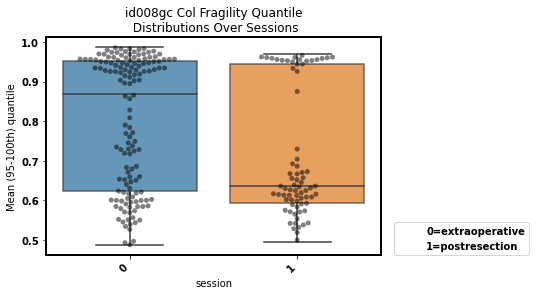

In [592]:
featurename = 'Col Fragility'

fig, ax = plt.subplots()
ax = sns.boxplot(data=df, x='session', y='qtile', order=ordered_ses_names, ax=ax, 
                 boxprops=dict(alpha=0.75))
ax = sns.swarmplot(data=df.sample(frac=0.3), x='session', y='qtile', color='black',
                   order=ordered_ses_names, ax=ax, alpha=0.5)
ax.set_xticklabels(
#     ax.get_xticklabels(),
    np.arange(len(ordered_ses_names)), 
                   rotation=45, ha='right')
ax.set(
    ylabel='Mean (95-100th) quantile',
    title=f'{subject} {featurename} Quantile\n Distributions Over Sessions'
)
# create blank rectangles
legend_actors = []
for idx in range(len(ordered_ses_names)):
    extra = mpl.patches.Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    legend_actors.append(extra)
ax.legend(legend_actors, list([f'{idx}={ses}' for idx, ses in enumerate(ordered_ses_names)]), 
         loc=(1.04, 0))
fig_fname = output_path / 'figures' / f'{subject}-{featurename}-boxplot-overallsessions.png'
fig.savefig(fig_fname,
           bbox_inches='tight')

In [593]:
shorthand_ses = {ses: f'{idx}' for idx, ses in enumerate(ordered_ses_names)}

In [594]:
df['session'] = df['session'].replace(shorthand_ses)

In [595]:
dabest_ses = dabest.load(df.sample(frac=0.2), x='session', y='qtile',
#                          idx=np.unique(session_names),
                        idx=np.arange(len(shorthand_ses)).astype(str),
                         resamples=500,
                   )

Done
Figure(432x288)


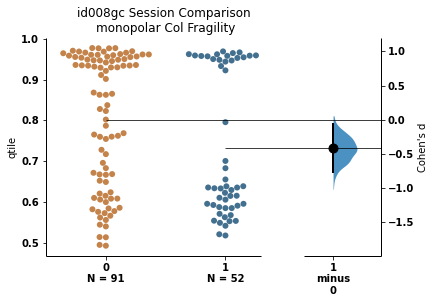

In [596]:
reference = 'monopolar'

fig, ax = plt.subplots()
fig = dabest_ses.cohens_d.plot(ax=ax)
ax.set(
    title=f'{subject} Session Comparison \n{reference} {featurename}'
)
print('Done')
print(fig)
fig_fname = output_path / 'figures' / f'{subject}-{featurename}-cohensd-overallsessions.png'
fig.savefig(
    fig_fname
)

# Discussion in context of real data from SickKids Hospital